In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif

/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(style="whitegrid")

In [3]:
for enc in ('utf-8', 'latin-1', 'cp1252'):
    try:
        df = pd.read_csv('stackoverflow_full.csv', encoding=enc, engine='python')
        print(f"Loaded with encoding: {enc}")
        break
    except UnicodeDecodeError:
        print(f"{enc} failed, trying next...")
else:
    # last-resort: read with replacement of bad bytes (keeps rows)
    df = pd.read_csv('stackoverflow_full.csv', encoding='utf-8', engine='python', encoding_errors='replace')
    print("Loaded with encoding_errors='replace' (some chars replaced).")
df = df.drop(columns=['Unnamed: 0'])
df.head()

utf-8 failed, trying next...
Loaded with encoding: latin-1


Age Accessibility        EdLevel  Employment Gender MentalHealth  \
0  <35            No         Master           1    Man           No   
1  <35            No  Undergraduate           1    Man           No   
2  <35            No         Master           1    Man           No   
3  <35            No  Undergraduate           1    Man           No   
4  >35            No            PhD           0    Man           No   

  MainBranch  YearsCode  YearsCodePro    Country  PreviousSalary  \
0        Dev          7             4     Sweden           51552   
1        Dev         12             5      Spain           46482   
2        Dev         15             6    Germany           77290   
3        Dev          9             6     Canada           46135   
4     NotDev         40            30  Singapore          160932   

                                      HaveWorkedWith  ComputerSkills  Employed  
0                          C++;Python;Git;PostgreSQL               4         0  
1  Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...              12         1  
2             C;C++;Java;Perl;Ruby;Git;Ruby on Rails               7         0  
3  Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...              13         0  
4                                         C++;Python               2         0

# EDA

In [5]:
df.isnull().sum()

Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

In [4]:
df.dropna(inplace=True)

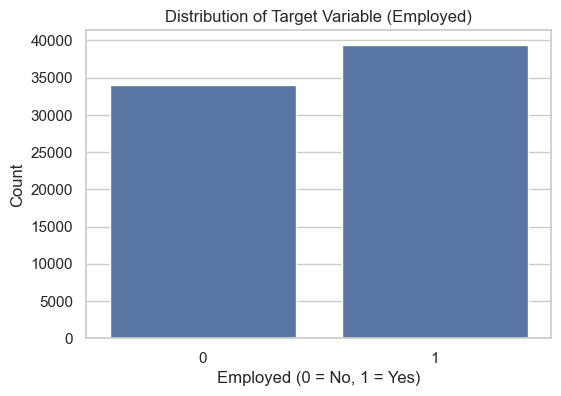

Employed
1    0.536683
0    0.463317
Name: proportion, dtype: float64


In [7]:
# 1. TARGET DISTRIBUTION
plt.figure(figsize=(6,4))
sns.countplot(x=df['Employed'])
plt.title("Distribution of Target Variable (Employed)")
plt.xlabel("Employed (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


# Print numeric balance
print(df['Employed'].value_counts(normalize=True))

In [8]:
# 3. NUMERIC FEATURE DISTRIBUTIONS

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Employed')

df[numeric_cols].hist(figsize=(15,12), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Employed','Employment'])

iqr_summary = []

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct_outliers = n_outliers / len(df) * 100

    iqr_summary.append({
        "feature": col,
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower_fence": lower,
        "upper_fence": upper,
        "#outliers": n_outliers,
        "%outliers": pct_outliers
    })

iqr_df = pd.DataFrame(iqr_summary).sort_values("%outliers", ascending=False)
display(iqr_df)


feature       Q1       Q3      IQR  lower_fence  upper_fence  \
1    YearsCodePro      3.0     12.0      9.0        -10.5         25.5   
0       YearsCode      7.0     20.0     13.0        -12.5         39.5   
3  ComputerSkills      8.0     17.0      9.0         -5.5         30.5   
2  PreviousSalary  28860.0  95979.0  67119.0     -71818.5     196657.5   

   #outliers  %outliers  
1       3349   4.562732  
0       1809   2.464611  
3       1633   2.224826  
2       1479   2.015014

- No need for outlier removal

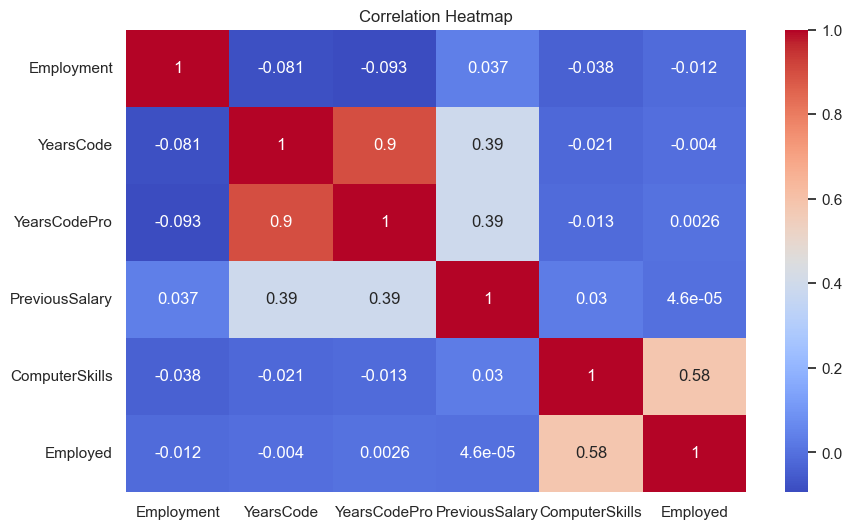

In [10]:
numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


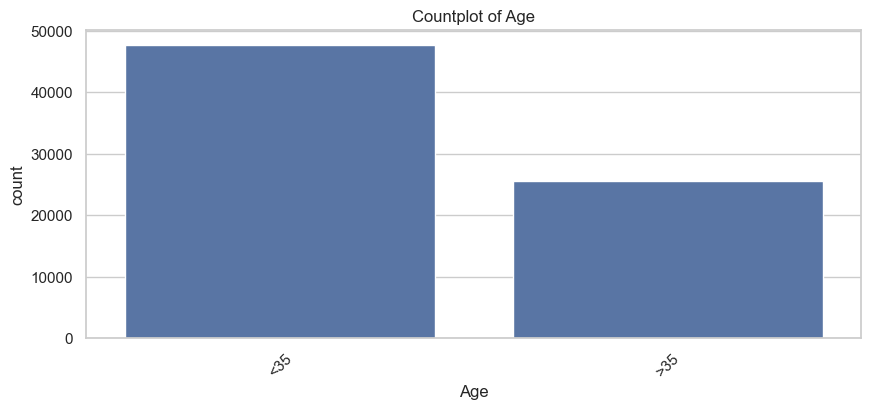

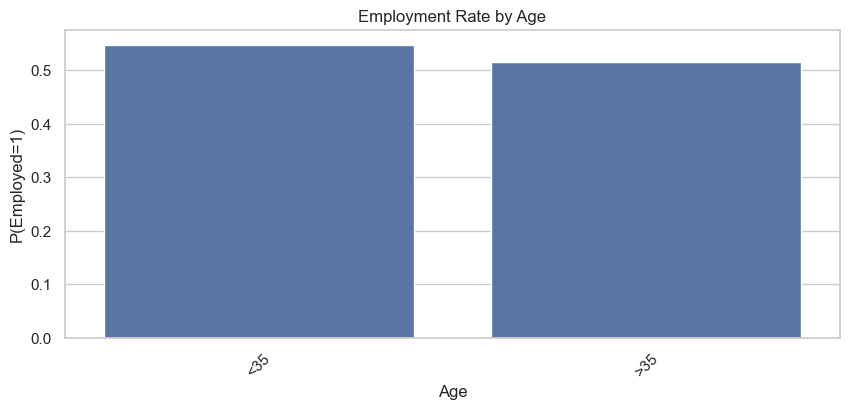

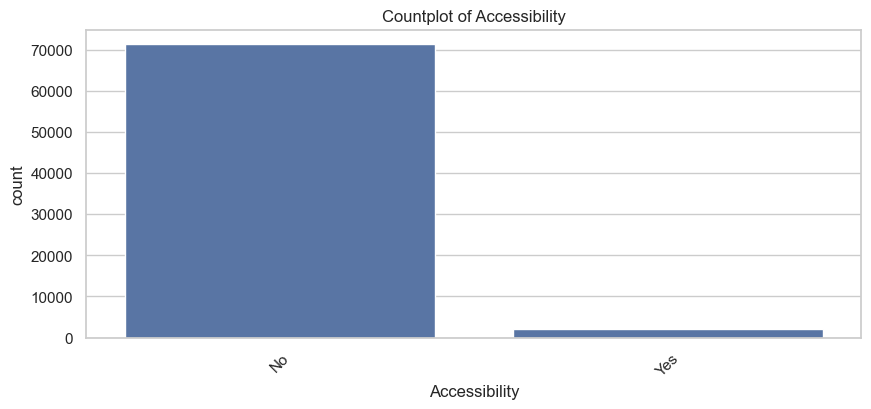

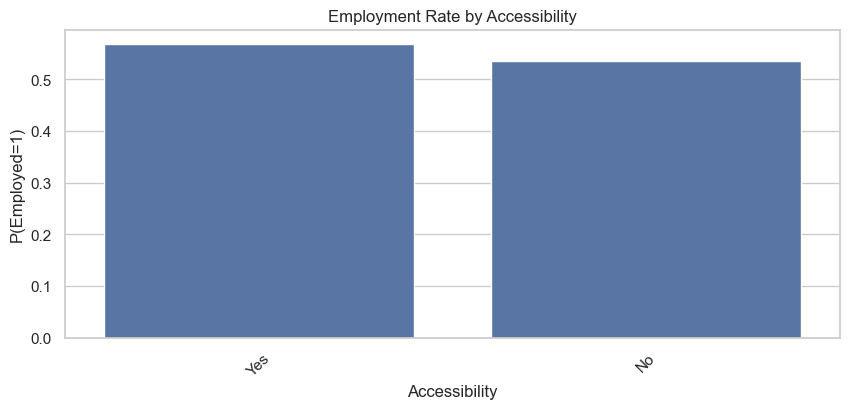

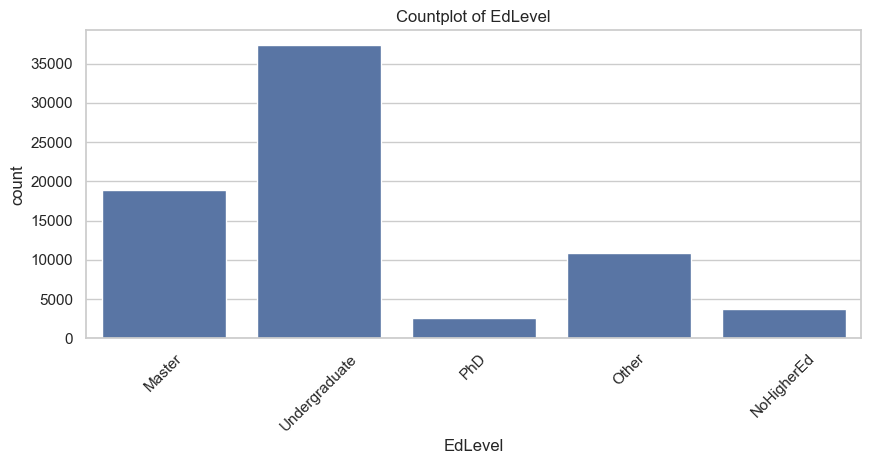

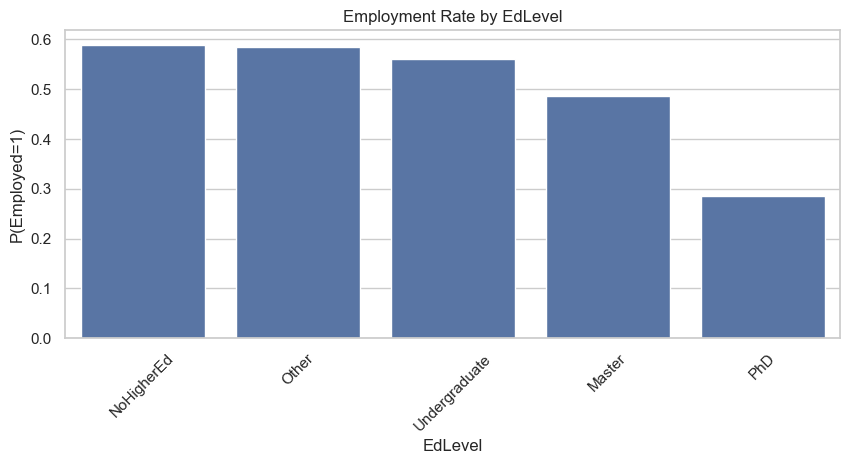

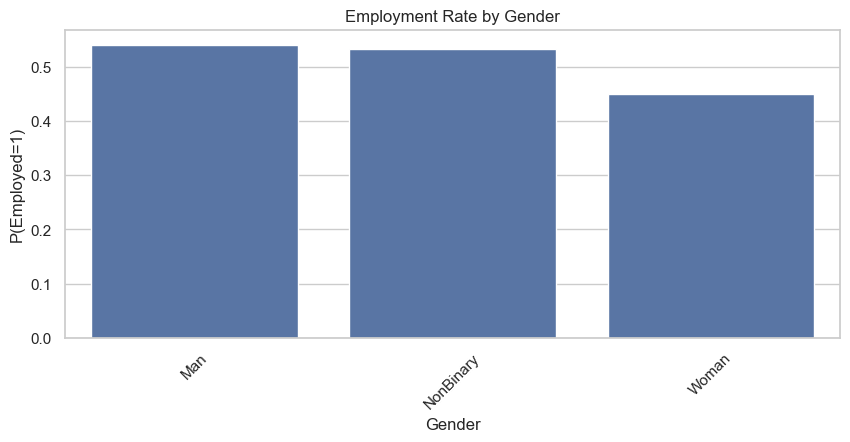

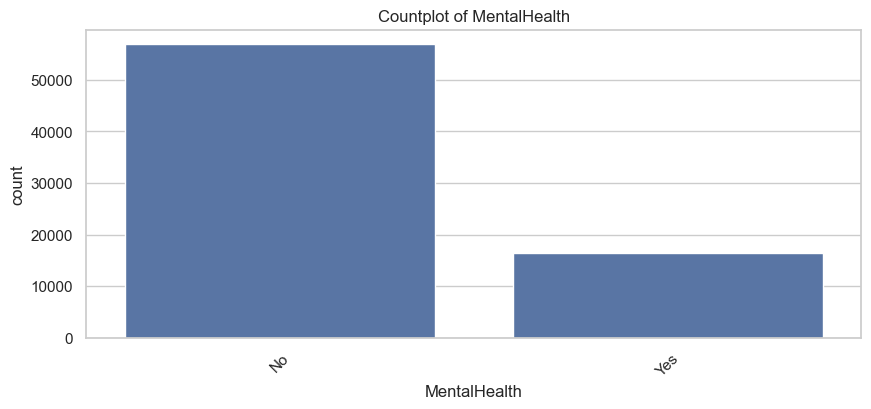

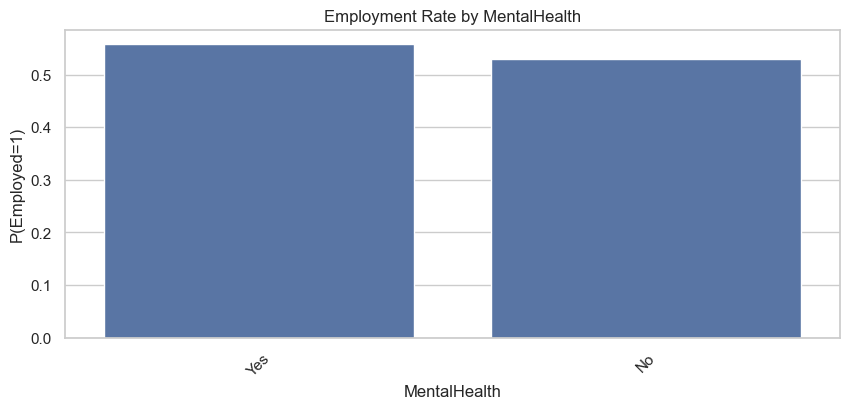

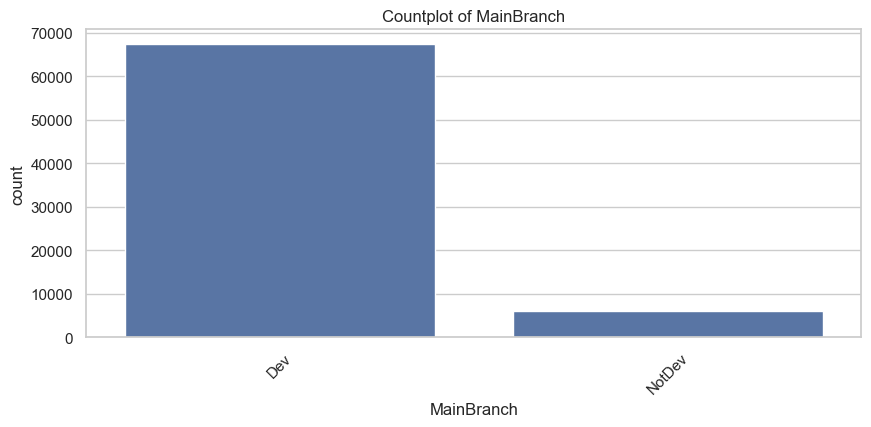

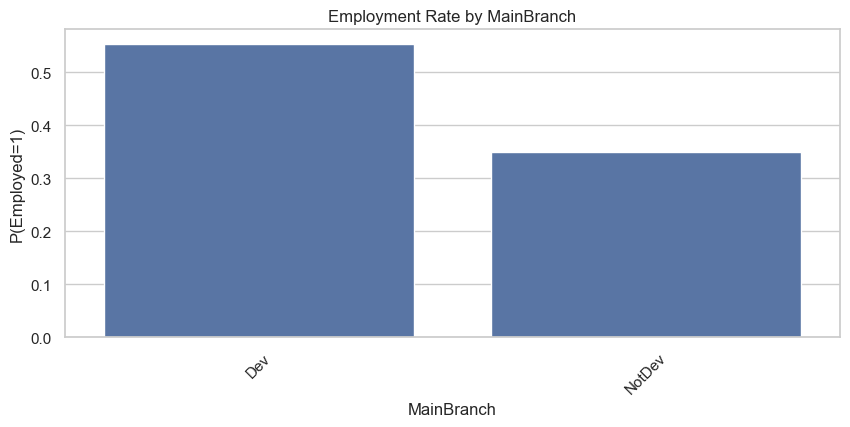

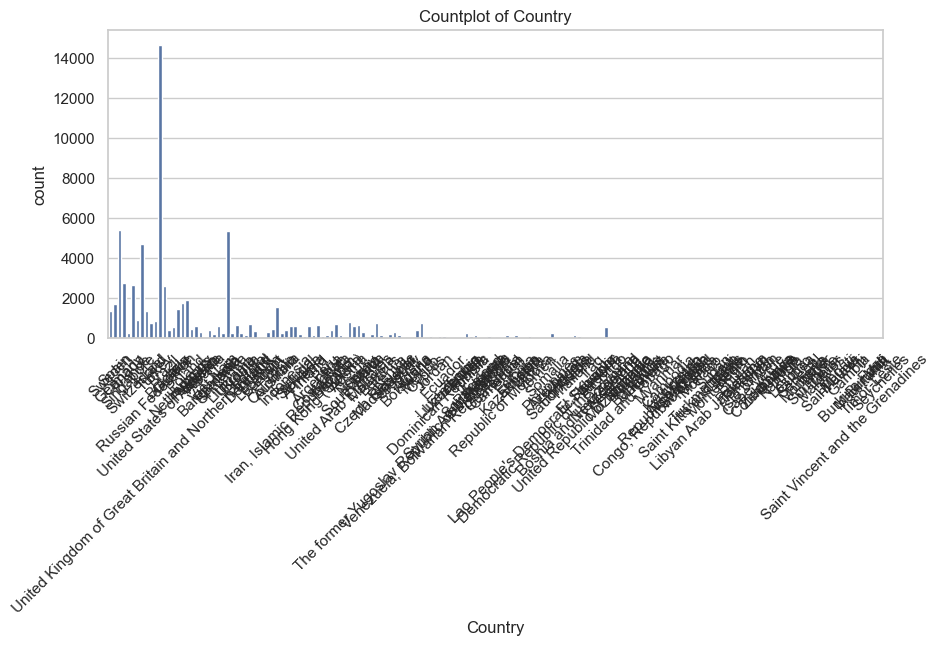

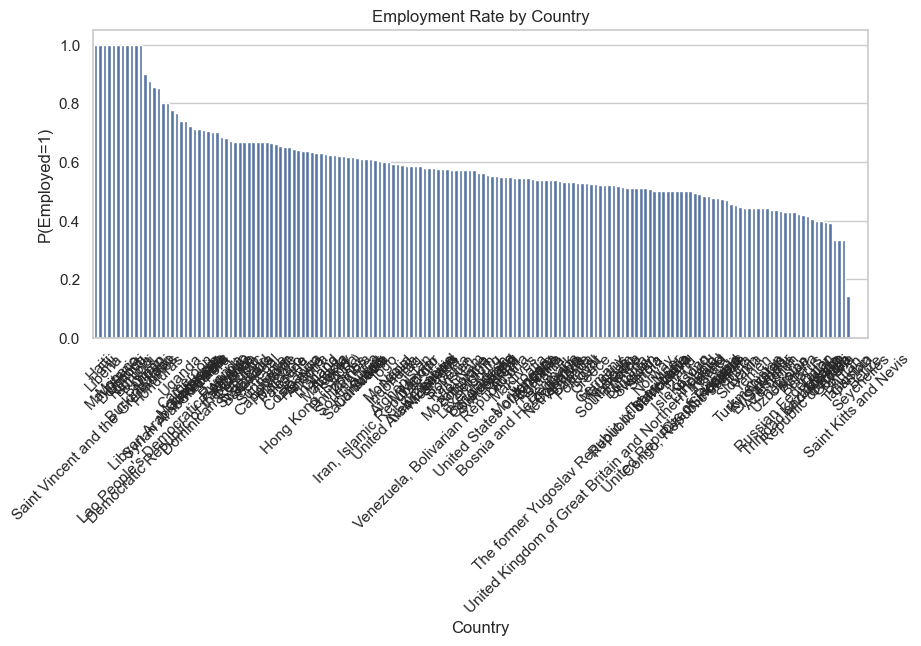

In [11]:
# 5. CATEGORICAL FEATURE ANALYSIS

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.drop('HaveWorkedWith')

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()

    # Target percentage per category
    plt.figure(figsize=(10,4))
    target_rate = df.groupby(col)['Employed'].mean().sort_values(ascending=False)
    sns.barplot(x=target_rate.index, y=target_rate.values)
    plt.xticks(rotation=45)
    plt.ylabel("P(Employed=1)")
    plt.title(f"Employment Rate by {col}")
    plt.show()

In [12]:
# 6. TEXT COLUMN EDA ("HaveWorkedWith")
text_col = "HaveWorkedWith"

# Generating word frequency
vectorizer = CountVectorizer(stop_words="english")
word_matrix = vectorizer.fit_transform(df[text_col].astype(str))
word_counts = np.asarray(word_matrix.sum(axis=0)).ravel()
vocab = np.array(vectorizer.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)

print("Top 20 most common tools/skills:")
display(freq_df.head(20))



Top 20 most common tools/skills:


word  count
58           js  73460
104         sql  58466
56   javascript  49347
28       docker  40224
20          css  40207
52         html  40207
69    microsoft  38068
45          git  35911
6           aws  31590
91       python  31159
87   postgresql  30102
71        mysql  29490
110  typescript  27533
74         node  26043
93        react  24695
73          net  22836
4           asp  22836
55         java  22653
101       shell  21929
8          bash  21929

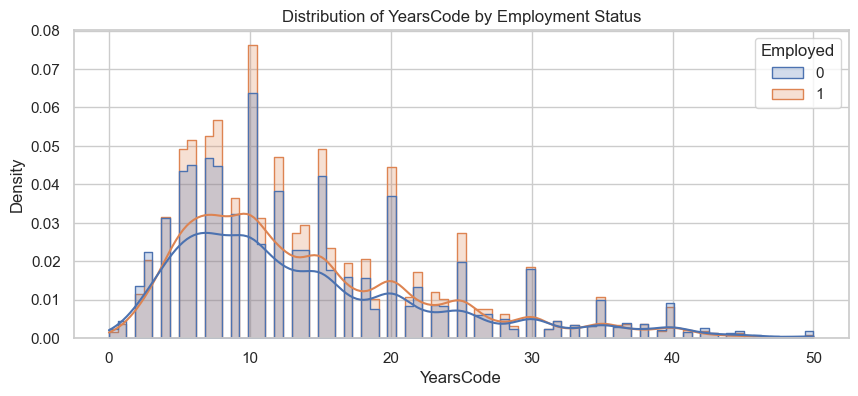

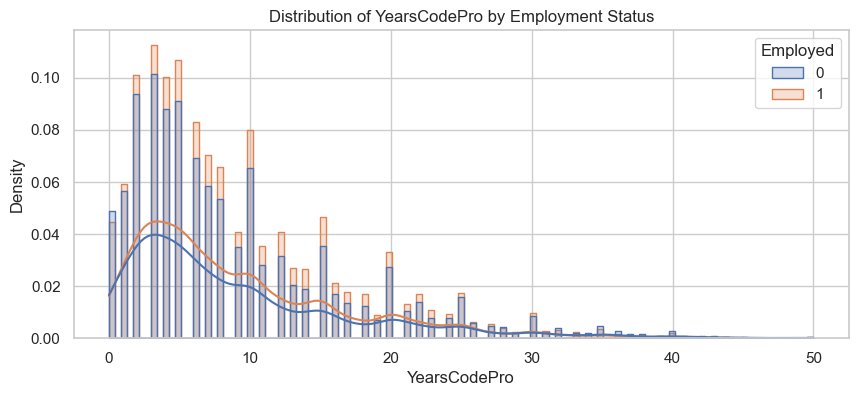

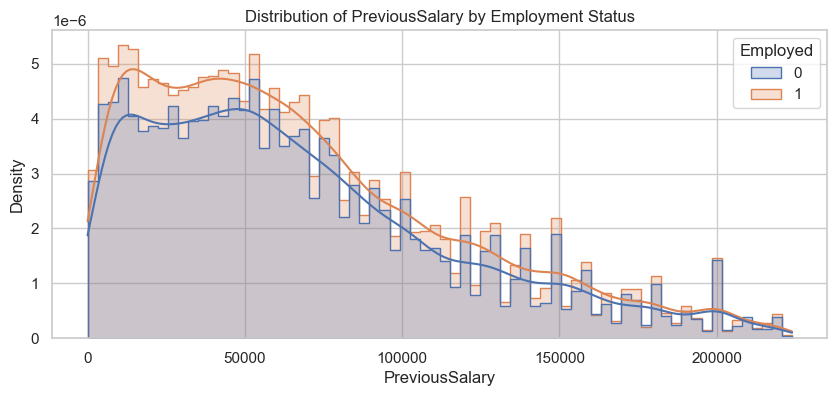

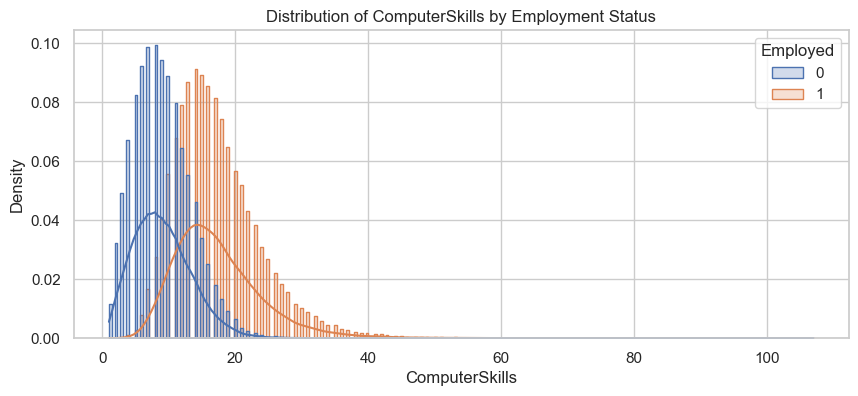

In [13]:
# 7. DISTRIBUTION OF NUMERIC FEATURES BY TARGET

for col in numeric_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df, x=col, hue='Employed', kde=True, element="step", stat="density")
    plt.title(f"Distribution of {col} by Employment Status")
    plt.show()

A small set of variables was removed after EDA because they offered little to no predictive signal.
• YearsCode and Age were dropped because both showed near-zero correlation with the target variable (as visible in the correlation heatmap), and were also highly collinear with YearsCodePro—adding noise without improving model accuracy.
• Gender, MentalHealth, and Accessibility displayed minimal differences in employment rates when visualized (see bar plots): each group shows nearly identical hiring probabilities.
Given their weak signal and potential to introduce unnecessary noise or ethical concerns, these features were excluded from the model 2.

In [15]:
columns_to_drop = ['YearsCode', 'Age','MentalHealth','Accessibility','Gender'] # removed based on correlation and observation
df = df.drop(columns=columns_to_drop, axis =1)

In [5]:
# 1. Preparing data & 60/20/20 splits

target_col = "Employed"

X = df.drop(columns=[target_col])
y = df[target_col].astype(int) 

# 60% train, 40% temp (valid+test), stratified
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 20% valid, 20% test from the temp set, stratified
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test :", X_test.shape, y_test.shape)

Shapes:
Train: (44039, 13) (44039,)
Valid: (14680, 13) (14680,)
Test : (14680, 13) (14680,)


Model 1: Skill-based Persona Approach:

We engineer features in two layers: **raw capabilities** and **personas**.
First, the raw `HaveWorkedWith` string is parsed into a set of skills and matched against curated groups: programming languages, front-end frameworks, back-end frameworks, SQL / NoSQL databases, cloud platforms and DevOps tools. For each candidate we then compute compact counts such as `num_langs`, `num_frontend_fw`, `num_db_sql`, `num_cloud`, `num_devops`, etc.

On top of these counts we define **persona flags** (0/1) that approximate real roles, e.g. `persona_programmer`, `persona_web_frontend`, `persona_web_backend`, `persona_data_engineer`, `persona_devops_engineer`, `persona_mobile_developer`, `persona_cloud_engineer`, `persona_database_admin`, and so on. Each persona is triggered only when a **specific combination** of skills is present (e.g. back-end framework + back-end language + database for web-backend, cloud + DevOps tools for cloud-engineer). These engineered features are then combined with standard profile information (education, years of coding, age band, self-reported computer skills, country/continent and salary level) inside `EmploymentPreprocessor`.

Intuitively, we expected that this design should help the model in two ways:

1. The **count features** summarise the overall breadth of a candidate’s toolbox (how many languages, DBs, clouds, etc.).
2. The **persona flags** capture whether their skill *bundle* resembles common industry roles, making it easier to see which types of profiles (e.g. data-engineers vs. mobile-developers vs. legacy enterprise devs) are more likely to be employed.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [7]:
# =====================================
# 2. Skill sets & country mapping
# =====================================

LANGS = {
    "APL", "Assembly",
    "C", "C#", "C++",
    "COBOL", "Crystal", "Dart", "Delphi",
    "Elixir", "Erlang",
    "F#", "Fortran",
    "Go", "Groovy",
    "Haskell",
    "Java", "JavaScript", "TypeScript",
    "Julia",
    "Kotlin",
    "LISP", "Lua",
    "MATLAB", "Matlab",
    "OCaml",
    "Objective-C",
    "Perl", "PHP", "Python",
    "R", "Ruby", "Rust",
    "SAS", "Scala", "Solidity",
    "Swift",
    "VBA"
}

WEB_CORE = {"HTML/CSS", "JavaScript", "TypeScript"}

FRONTEND_FW = {
    "React.js", "Vue.js", "Angular", "Angular.js",
    "Svelte", "jQuery",
    "Next.js", "Nuxt.js", "Gatsby", "Blazor", "Flow"
}

BACKEND_FW = {
    "Node.js", "Express", "Deno",
    "Django", "Flask", "FastAPI", "Fastify",
    "Laravel", "Ruby on Rails", "Spring", "Symfony",
    "Phoenix", "Play Framework",
    "ASP.NET", "ASP.NET Core",
    "Drupal"
}

DB_SQL = {
    "MySQL", "PostgreSQL", "SQLite",
    "Microsoft SQL Server", "MariaDB",
    "Oracle", "IBM DB2"
}

DB_NOSQL = {
    "MongoDB", "Cassandra", "CouchDB", "Couchbase",
    "DynamoDB", "Redis", "Neo4j",
    "Firebase", "Firebase Realtime Database", "Cloud Firestore",
    "Elasticsearch"
}

DB_ANY = DB_SQL | DB_NOSQL
SQL_TECH = DB_SQL | {"SQL"}

CLOUD_PROVIDERS = {
    "AWS",
    "Google Cloud", "Google Cloud Platform",
    "Microsoft Azure",
    "IBM Cloud or Watson",
    "Oracle Cloud Infrastructure",
    "DigitalOcean", "Linode", "OVH",
    "Heroku", "Managed Hosting", "Colocation",
    "OpenStack", "VMware"
}

DEVOPS_TOOLS = {
    "Docker", "Kubernetes",
    "Terraform", "Pulumi",
    "Ansible", "Chef", "Puppet",
    "Bash/Shell", "PowerShell",
    "Homebrew", "Yarn", "npm", "Git"
}

DATA_LANGS = {"Python", "R", "SAS", "MATLAB", "Matlab"}
MOBILE_TOOLS = {"Swift", "Kotlin", "Xamarin"}
MOBILE_LANGS = {"Java", "C#", "Dart"}
GAME_ENGINES = {"Unity 3D", "Unreal Engine"}
GAME_LANGS = {"C#", "C++", "C"}
FUNCTIONAL_LANGS = {"Haskell", "Scala", "Clojure", "F#", "OCaml", "Elixir", "Erlang", "LISP"}
LOWLEVEL = {"C", "C++", "Rust", "Fortran", "COBOL", "Assembly"}
SCRIPTING = {"Bash/Shell", "PowerShell", "VBA"}
LEGACY_STACK = {"COBOL", "Fortran", "IBM DB2", "Oracle", "SAS", "VBA", "IBM Cloud or Watson"}

country_to_continent = {
    # Europe
    'Sweden': 'Europe', 'Spain': 'Europe', 'Germany': 'Europe', 'France': 'Europe',
    'Switzerland': 'Europe', 'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'Russian Federation': 'Europe', 'Italy': 'Europe', 'Netherlands': 'Europe',
    'Poland': 'Europe', 'Hungary': 'Europe', 'Bulgaria': 'Europe', 'Greece': 'Europe',
    'Romania': 'Europe', 'Lithuania': 'Europe', 'Ukraine': 'Europe', 'Croatia': 'Europe',
    'Georgia': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe', 'Portugal': 'Europe',
    'Slovakia': 'Europe', 'Armenia': 'Europe', 'Finland': 'Europe', 'Belgium': 'Europe',
    'Austria': 'Europe', 'Norway': 'Europe', 'Serbia': 'Europe', 'Malta': 'Europe',
    'Czech Republic': 'Europe', 'Belarus': 'Europe', 'Slovenia': 'Europe',
    'The former Yugoslav Republic of Macedonia': 'Europe', 'Cyprus': 'Europe',
    'Luxembourg': 'Europe', 'Iceland': 'Europe', 'Bosnia and Herzegovina': 'Europe',
    'Estonia': 'Europe', 'Latvia': 'Europe', 'Kosovo': 'Europe', 'Andorra': 'Europe',
    'Montenegro': 'Europe', 'Monaco': 'Europe', 'Isle of Man': 'Europe', 'Republic of Moldova': 'Europe',

    # Asia
    'Singapore': 'Asia', 'Israel': 'Asia', 'Turkey': 'Asia', 'Pakistan': 'Asia',
    'Bangladesh': 'Asia', 'Viet Nam': 'Asia', 'India': 'Asia', 'Lebanon': 'Asia',
    'Bahrain': 'Asia', 'Iran, Islamic Republic of...': 'Asia', 'Hong Kong (S.A.R.)': 'Asia',
    'Japan': 'Asia', 'United Arab Emirates': 'Asia', 'Malaysia': 'Asia', 'China': 'Asia',
    'Taiwan': 'Asia', 'South Korea': 'Asia', 'Nepal': 'Asia', 'Kazakhstan': 'Asia',
    'Uzbekistan': 'Asia', 'Syrian Arab Republic': 'Asia', 'Jordan': 'Asia',
    'Saudi Arabia': 'Asia', 'Thailand': 'Asia', 'Azerbaijan': 'Asia',
    'Iraq': 'Asia', 'Kuwait': 'Asia', 'Myanmar': 'Asia', 'Republic of Korea': 'Asia',
    'Cambodia': 'Asia', 'Kyrgyzstan': 'Asia', 'Afghanistan': 'Asia', 'Turkmenistan': 'Asia',
    'Palestine': 'Asia', 'Tajikistan': 'Asia', 'Oman': 'Asia', 'Maldives': 'Asia',
    'Qatar': 'Asia', 'Mongolia': 'Asia', 'Bhutan': 'Asia', 'Timor-Leste': 'Asia', 'Sri Lanka': 'Asia',
    'Indonesia': 'Asia', "Lao People's Democratic Republic": 'Asia', 'Philippines': 'Asia',
    'Yemen': 'Asia',

    # Africa
    'Nigeria': 'Africa', 'Albania': 'Europe', 'Egypt': 'Africa', 'South Africa': 'Africa',
    'Madagascar': 'Africa', 'Kenya': 'Africa', 'Botswana': 'Africa', 'Algeria': 'Africa',
    'Ethiopia': 'Africa', 'Zambia': 'Africa', 'Tunisia': 'Africa', 'Cameroon': 'Africa',
    'Somalia': 'Africa', 'Angola': 'Africa', 'United Republic of Tanzania': 'Africa',
    'Mozambique': 'Africa', 'Ghana': 'Africa', 'Congo, Republic of the...': 'Africa',
    'Democratic Republic of the Congo': 'Africa', 'Uganda': 'Africa', 'Swaziland': 'Africa',
    'Rwanda': 'Africa', 'Sudan': 'Africa', 'Libyan Arab Jamahiriya': 'Africa',
    'Zimbabwe': 'Africa', 'Mauritius': 'Africa', 'Namibia': 'Africa', 'Togo': 'Africa',
    'Lesotho': 'Africa', 'Guinea': 'Africa', 'Senegal': 'Africa', 'Liberia': 'Africa',
    'Niger': 'Africa', 'Djibouti': 'Africa', 'Malawi': 'Africa', 'Gambia': 'Africa',
    'Burkina Faso': 'Africa', 'Mauritania': 'Africa', 'Burundi': 'Africa', 'Mali': 'Africa',
    'Benin': 'Africa', "Côte d'Ivoire": 'Africa', 'Cape Verde': 'Africa', 'Seychelles': 'Africa', 'Morocco': 'Africa',
    "CÃ´te d'Ivoire": 'Africa',

    # North America
    'Canada': 'North America', 'United States of America': 'North America', 'Mexico': 'North America',
    'Costa Rica': 'North America', 'Cuba': 'North America', 'Dominican Republic': 'North America',
    'Guatemala': 'North America', 'Honduras': 'North America', 'El Salvador': 'North America',
    'Panama': 'North America', 'Nicaragua': 'North America', 'Haiti': 'North America',
    'Belize': 'North America', 'Jamaica': 'North America',

    # South America
    'Brazil': 'South America', 'Colombia': 'South America', 'Chile': 'South America',
    'Argentina': 'South America', 'Peru': 'South America', 'Bolivia': 'South America',
    'Venezuela, Bolivarian Republic of...': 'South America', 'Ecuador': 'South America',
    'Paraguay': 'South America', 'Uruguay': 'South America', 'Guyana': 'South America',
    'Suriname': 'South America', 'Venezuela, Bolivarian Republic ofÉ': 'South America',

    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania', 'Fiji': 'Oceania',

    # Caribbean (included under North America here)
    'Trinidad and Tobago': 'North America', 'Barbados': 'North America', 'Dominica': 'North America',
    'Saint Kitts and Nevis': 'North America', 'Saint Lucia': 'North America',
    'Saint Vincent and the Grenadines': 'North America',

    # Other
    'Nomadic': 'Other',
}

def country_to_continent_fn(country):
    if pd.isna(country):
        return "Other"
    return country_to_continent.get(country, "Other")

# =====================================
# 3. Helpers
# =====================================

def parse_skills(raw):
    if pd.isna(raw):
        return []
    if isinstance(raw, (list, tuple, set)):
        parts = [str(s).strip() for s in raw]
    else:
        parts = [s.strip() for s in str(raw).split(";")]
    return [p for p in parts if p]

def safe_years_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s_low = s.lower()
    if s_low in ("less than 1 year", "<1", "< 1", "0"):
        return 0.5
    if s_low.startswith("more than"):
        try:
            n = float(s.split()[-2])
            return n
        except Exception:
            return 50.0
    try:
        return float(s)
    except Exception:
        m = re.search(r"\d+(\.\d+)?", s)
        if m:
            return float(m.group(0))
        return np.nan

def persona_feature_dict(skills_list):
    """
    Build skill-count features + persona flags from a list of skills.

    Personas (all derived ONLY from the given skill sets):
      - programmer
      - web_frontend
      - web_backend
      - data_analyst
      - data_engineer
      - devops_engineer
      - mobile_developer
      - legacy_enterprise_dev
      - cloud_engineer
      - functional_programmer
      - lowlevel_engineer
      - game_developer
      - database_admin
    """
    skills = set(skills_list)

    # --- Group intersections (for reuse) ---
    langs         = skills & LANGS
    web_core      = skills & WEB_CORE
    fe_fw         = skills & FRONTEND_FW
    be_fw         = skills & BACKEND_FW
    db_sql        = skills & DB_SQL
    db_nosql      = skills & DB_NOSQL
    db_any        = db_sql | db_nosql
    cloud         = skills & CLOUD_PROVIDERS
    devops        = skills & DEVOPS_TOOLS
    data_langs    = skills & DATA_LANGS
    mobile_tools  = skills & MOBILE_TOOLS
    mobile_langs  = skills & MOBILE_LANGS
    game_engines  = skills & GAME_ENGINES
    game_langs    = skills & GAME_LANGS
    functional    = skills & FUNCTIONAL_LANGS
    lowlevel      = skills & LOWLEVEL
    scripting     = skills & SCRIPTING
    legacy        = skills & LEGACY_STACK

    # --- Helper sets (all built from your skills only) ---
    CORE_PROG_LANGS      = {"C", "C++", "Java", "C#", "Go", "Rust",
                            "Kotlin", "Scala", "Swift", "Dart",
                            "TypeScript", "JavaScript", "Python",
                            "Ruby", "PHP"}
    BACKEND_LANGS        = {"JavaScript", "TypeScript", "Java", "C#",
                            "PHP", "Python", "Ruby", "Go", "Kotlin",
                            "Dart", "Scala"}
    ANALYST_LANGS        = {"R", "SAS", "MATLAB", "Matlab"}
    DATA_ENGINEER_LANGS  = {"Python", "Scala", "Java"}
    # SQL appears as a separate skill in your data
    has_sql_like         = (len(db_sql) > 0) or ("SQL" in skills)

    # =====================================================
    # Persona definitions (try to avoid noisy flags)
    # =====================================================

    # 1) General programmer:
    #    - Either: at least 2 core general-purpose langs
    #    - Or: at least 3 total languages from LANGS
    is_programmer = (len(langs & CORE_PROG_LANGS) >= 2) or (len(langs) >= 3)

    # 2) Web frontend:
    #    - At least 1 frontend framework
    #    - AND at least one web core tech (HTML/CSS, JS, TS)
    is_web_frontend = (len(fe_fw) >= 1) and (len(web_core) >= 1)

    # 3) Web backend:
    #    - At least 1 backend framework
    #    - AND at least one backend language
    #    - AND some database/SQL exposure
    is_web_backend = (
        (len(be_fw) >= 1) and
        (len(langs & BACKEND_LANGS) >= 1) and
        (len(db_any) >= 1 or "SQL" in skills)
    )

    # 4) Data analyst:
    #    - At least one "analyst" language (R, SAS, MATLAB)
    #    - AND SQL / relational DB exposure
    is_data_analyst = (
        (len(skills & ANALYST_LANGS) >= 1) and
        has_sql_like
    )

    # 5) Data engineer:
    #    - At least one data-engineer language (Python / Scala / Java)
    #    - AND at least one DB (SQL or NoSQL)
    #    - AND at least one cloud provider
    #    - AND at least one DevOps tool (Docker, Terraform, etc.)
    is_data_engineer = (
        (len(skills & DATA_ENGINEER_LANGS) >= 1) and
        (len(db_any) >= 1) and
        (len(cloud) >= 1) and
        (len(devops) >= 1)
    )

    # 6) DevOps engineer:
    #    - At least 2 DevOps tools
    #    - AND (cloud OR scripting) to suggest infra focus
    is_devops_engineer = (
        (len(devops) >= 2) and
        (len(cloud) >= 1 or len(scripting) >= 1)
    )

    # 7) Mobile developer:
    #    - At least one mobile tool (Swift/Kotlin/Xamarin)
    #    - AND at least one mobile language (Java, C#, Dart)
    is_mobile_developer = (
        (len(mobile_tools) >= 1) and
        (len(mobile_langs) >= 1)
    )

    # 8) Legacy enterprise developer:
    #    - Strong evidence via COBOL / Fortran / IBM DB2
    #    - OR at least 2 legacy stack items (SAS, Oracle, VBA, IBM Cloud...)
    is_legacy_enterprise_dev = (
        (len(legacy & {"COBOL", "Fortran", "IBM DB2"}) >= 1) or
        (len(legacy) >= 2)
    )

    # 9) Cloud engineer:
    #    - At least one cloud provider
    #    - AND some infra / automation signal (DevOps or scripting)
    is_cloud_engineer = (
        (len(cloud) >= 1) and
        (len(devops) >= 1 or len(scripting) >= 1)
    )

    # 10) Functional programmer:
    #     - At least one functional language (Haskell, Scala, Clojure, F#, OCaml, Elixir, Erlang, LISP)
    is_functional_programmer = (len(functional) >= 1)

    # 11) Low-level / systems engineer:
    #     - At least 2 low-level langs
    #       (C, C++, Rust, Fortran, COBOL, Assembly)
    is_lowlevel_engineer = (len(lowlevel) >= 2)

    # 12) Game developer:
    #     - A game engine (Unity 3D / Unreal Engine)
    #     - AND a game language (C#, C++, C)
    is_game_developer = (
        (len(game_engines) >= 1) and
        (len(game_langs) >= 1)
    )

    # 13) Database admin:
    #     - Either: 2+ SQL databases
    #     - OR: mix of SQL + NoSQL
    #     - OR: 3+ distinct database techs overall
    is_database_admin = (
        (len(db_sql) >= 2) or
        (len(db_sql) >= 1 and len(db_nosql) >= 1) or
        (len(db_any) >= 3)
    )

    # =====================================================
    # Output feature dict (counts + persona flags)
    # =====================================================
    out = {}

    # Counts (still useful numerical signals)
    # out["num_skills"]       = len(skills_list)
    out["num_langs"]        = len(langs)
    out["num_frontend_fw"]  = len(fe_fw)
    out["num_backend_fw"]   = len(be_fw)
    out["num_db_sql"]       = len(db_sql)
    out["num_db_nosql"]     = len(db_nosql)
    out["num_cloud"]        = len(cloud)
    out["num_devops"]       = len(devops)

    # Persona flags
    out["persona_programmer"]            = int(is_programmer)
    out["persona_web_frontend"]         = int(is_web_frontend)
    out["persona_web_backend"]          = int(is_web_backend)
    out["persona_data_analyst"]         = int(is_data_analyst)
    out["persona_data_engineer"]        = int(is_data_engineer)
    out["persona_devops_engineer"]      = int(is_devops_engineer)
    out["persona_mobile_developer"]     = int(is_mobile_developer)
    out["persona_legacy_enterprise_dev"]= int(is_legacy_enterprise_dev)
    out["persona_cloud_engineer"]       = int(is_cloud_engineer)
    out["persona_functional_programmer"]= int(is_functional_programmer)
    out["persona_lowlevel_engineer"]    = int(is_lowlevel_engineer)
    out["persona_game_developer"]       = int(is_game_developer)
    out["persona_database_admin"]       = int(is_database_admin)

    return out

# =====================================
# 4. EmploymentPreprocessor (fixed to expose feature names)
# =====================================

class EmploymentPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, country_target_encode=True, pca_on_skills=False, pca_components=5, random_state=42):
        self.country_target_encode = country_target_encode
        self.pca_on_skills = pca_on_skills
        self.pca_components = pca_components
        self.random_state = random_state

    def fit(self, X, y=None):
        X = X.copy()

        # EdLevel mapping + median
        self.ed_map_ = {"High school":0, "Undergraduate":1, "Master":2, "PhD":3}
        ed_ord = X["EdLevel"].map(self.ed_map_).astype(float)
        self.ed_median_ = float(ed_ord.median(skipna=True)) if not ed_ord.isna().all() else 1.0

        # Country target encoding
        if self.country_target_encode and y is not None:
            country_ser = X["Country"].fillna("Other").astype(str)
            dfc = pd.DataFrame({"country": country_ser.values, "y": pd.Series(y).values})
            self.country_mean_map_ = dfc.groupby("country")["y"].mean().to_dict()
            self.country_global_mean_ = float(pd.Series(y).mean())
        else:
            self.country_mean_map_, self.country_global_mean_ = {}, 0.0

        # Country salary medians
        self.country_salary_median_ = X.groupby("Country")["PreviousSalary"].median().to_dict()

        # Optional PCA on skills
        if self.pca_on_skills:
            skill_lists = X["HaveWorkedWith"].apply(parse_skills)
            from collections import Counter
            all_sk = Counter([s for lst in skill_lists for s in lst])
            top_sk = [s for s,_ in all_sk.most_common(200)]
            self.skill_vocab_ = top_sk
            M = np.zeros((len(skill_lists), len(top_sk)), dtype=float)
            for i, lst in enumerate(skill_lists):
                for s in lst:
                    if s in top_sk:
                        M[i, top_sk.index(s)] = 1.0
            self.pca_ = PCA(self.pca_components, random_state=self.random_state)
            if M.sum() > 0:
                self.pca_.fit(M)
            else:
                self.pca_ = None
        else:
            self.pca_ = None
            self.skill_vocab_ = None

        # Build features on TRAIN ONLY to define columns
        feat_df = self._make_features(X)
        self.feature_columns_ = list(feat_df.columns)
        self.feature_names_ = np.array(self.feature_columns_)

        # Fit imputer & scaler on train features
        self.num_imputer_ = SimpleImputer(strategy="median")
        self.num_imputer_.fit(feat_df.values)
        self.scaler_ = StandardScaler()
        self.scaler_.fit(self.num_imputer_.transform(feat_df.values))
        return self

    def _make_features(self, X):
        X = X.copy()
        out = pd.DataFrame(index=X.index)

        # Salary
        out["PreviousSalary"] = pd.to_numeric(X["PreviousSalary"], errors="coerce")
        out["PreviousSalary_log"] = np.log1p(out["PreviousSalary"])
        country = X["Country"].fillna("Other").astype(str)
        out["country_salary_median"] = [self.country_salary_median_.get(c, np.nan) for c in country]
        out["PreviousSalary_relative"] = out["PreviousSalary"] / (out["country_salary_median"] + 1e-9)

        # Education
        out["EdLevel_ord"] = X["EdLevel"].map(self.ed_map_).astype(float)
        out["EdLevel_is_other"] = X["EdLevel"].isin(["Other","Others"]).astype(int)
        out["EdLevel_ord"] = out["EdLevel_ord"].fillna(self.ed_median_)

        # Experience
        out["YearsCode"] = X["YearsCode"].apply(safe_years_to_float)
        out["YearsCodePro"] = X["YearsCodePro"].apply(safe_years_to_float)
        out["YearsCode"].fillna(out["YearsCode"].median(), inplace=True)
        out["YearsCodePro"].fillna(out["YearsCodePro"].median(), inplace=True)
        out["exp_gap"] = out["YearsCode"] - out["YearsCodePro"]
        out["exp_ratio"] = out["YearsCodePro"] / (out["YearsCode"] + 1e-6)

        # Age: binary flag <35
        out["Age_lt35"] = (X["Age"] == "<35").astype(int)

        # Binary flags
        out["Accessibility_bin"] = X["Accessibility"].map({"Yes":1,"No":0}).fillna(0).astype(int)
        out["MentalHealth_bin"] = X["MentalHealth"].map({"Yes":1,"No":0}).fillna(0).astype(int)
        out["MainBranch_Dev"] = (X["MainBranch"] == "Dev").astype(int)
        out["is_Man"] = (X["Gender"] == "Man").astype(int)
        out["is_Woman"] = (X["Gender"] == "Woman").astype(int)

        # Country -> continent dummies
        out["Country_continent"] = X["Country"].apply(country_to_continent_fn)
        continent_dummies = pd.get_dummies(out["Country_continent"], prefix="Continent")
        out = pd.concat([out, continent_dummies], axis=1)
        out = out.drop(columns=["Country_continent"])

        # Country target encoding
        if hasattr(self, "country_mean_map_") and self.country_target_encode:
            out["Country_te"] = X["Country"].fillna("Other").astype(str).map(self.country_mean_map_).fillna(self.country_global_mean_)
        else:
            out["Country_te"] = 0.0
        out["ComputerSkills"] = X["ComputerSkills"]
        out["PreviousEmployment"] = X["Employment"]
        # Skills & personas
        skill_lists = X["HaveWorkedWith"].apply(parse_skills)
        persona_rows = [persona_feature_dict(lst) for lst in skill_lists]
        persona_df = pd.DataFrame(persona_rows, index=X.index)
        out = pd.concat([out, persona_df], axis=1)
    
        # out["num_unique_skills"] = skill_lists.apply(lambda L: len(set(L)))
        # out["num_skill_tokens"] = skill_lists.apply(len)

        # PCA components (if enabled)
        if self.pca_ is not None and self.skill_vocab_ is not None:
            vocab = self.skill_vocab_
            M = np.zeros((len(skill_lists), len(vocab)), dtype=float)
            for i,lst in enumerate(skill_lists):
                for s in lst:
                    if s in vocab:
                        j = vocab.index(s)
                        M[i,j] = 1.0
            comps = self.pca_.transform(M) if self.pca_ is not None else None
            if comps is not None:
                comps_df = pd.DataFrame(comps, index=X.index, columns=[f"skill_pca_{i}" for i in range(comps.shape[1])])
                out = pd.concat([out, comps_df], axis=1)

        return out

    def transform(self, X):
        # Build features for this split
        feat_df = self._make_features(X)

        # Align columns to training feature set
        feat_df = feat_df.reindex(columns=self.feature_columns_, fill_value=np.nan)

        # Impute & scale
        arr = self.num_imputer_.transform(feat_df.values)
        arr = self.scaler_.transform(arr)
        df_scaled = pd.DataFrame(arr, index=feat_df.index, columns=self.feature_columns_)
        return df_scaled

    def get_feature_names_out(self):
        """Return feature names after preprocessing (for SHAP/LIME)."""
        return np.array(self.feature_columns_)


Fitting preprocessor on training data...


/var/folders/zr/hq_q97d52l1ck8p_4myglv4r0000gn/T/ipykernel_7177/3946451959.py:472: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  out["YearsCode"].fillna(out["YearsCode"].median(), inplace=True)
/var/folders/zr/hq_q97d52l1ck8p_4myglv4r0000gn/T/ipykernel_7177/3946451959.py:473: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

Processed shapes - Train: (44039, 46), Valid: (14680, 46), Test: (14680, 46)

Defining models...

Training glassbox_L2_Ridge...


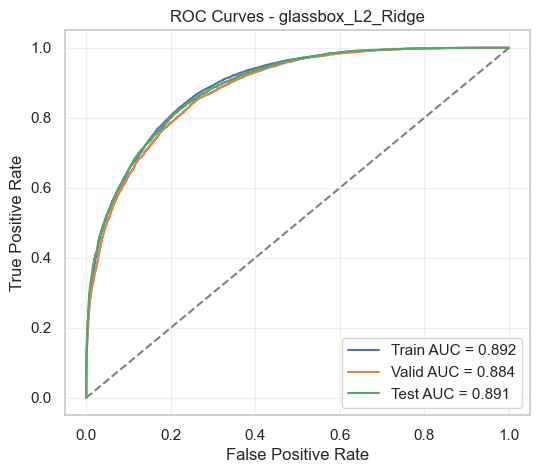

Training glassbox_logloss_LogReg...


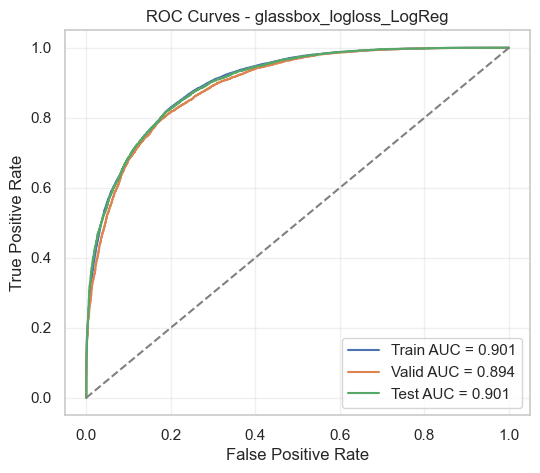

Training blackbox_L2_GBReg...


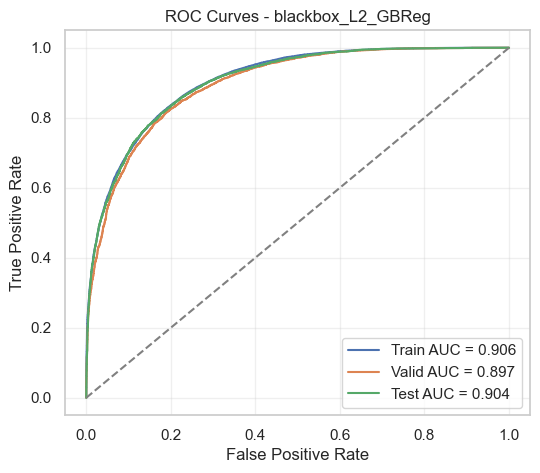

Training blackbox_logloss_GBCls...


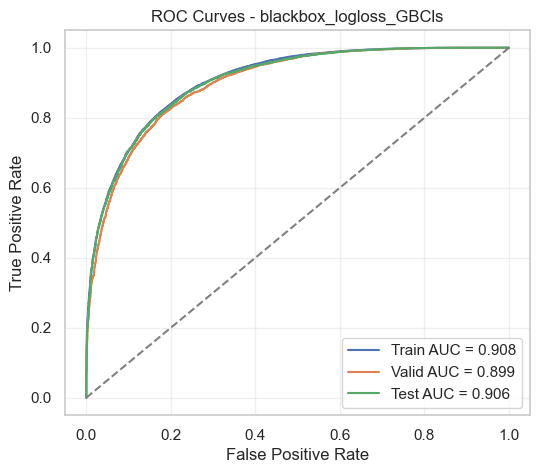


RESULTS SUMMARY (sorted by Validation AUC)
                model_name  auc_train  auc_valid  auc_test  best_threshold  eval_loss_valid  eval_loss_test
3   blackbox_logloss_GBCls   0.907856   0.899398  0.905565        0.162097           4411.0          4455.0
2        blackbox_L2_GBReg   0.906336   0.897435  0.904270        0.161004           4491.0          4428.0
1  glassbox_logloss_LogReg   0.901301   0.893727  0.900919        0.152798           4517.0          4485.0
0        glassbox_L2_Ridge   0.892247   0.883602  0.890626       -0.451071           4679.0          4669.0

✓ Best model selected: blackbox_logloss_GBCls
  - Validation AUC: 0.8994
  - Test AUC: 0.9056
  - Best threshold: 0.1621

FINAL TEST SET EVALUATION (Best Model)

Test AUC: 0.9056
Evaluation Loss (test): 4455.00

Classification Report:
              precision    recall  f1-score   support

Not Employed       0.95      0.47      0.63      6802
    Employed       0.68      0.98      0.80      7878

    accuracy    

In [8]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from copy import deepcopy

def train_and_evaluate_employment_models(X_train, y_train, X_valid, y_valid, X_test, y_test):
    """
    Complete pipeline using EmploymentPreprocessor with multiple models.
    """
    print("Fitting preprocessor on training data...")
    preprocessor = EmploymentPreprocessor(
        country_target_encode=True,
        pca_on_skills=False,
        random_state=42
    )
    preprocessor.fit(X_train, y_train)

    # Transform splits
    X_train_proc = preprocessor.transform(X_train)
    X_valid_proc = preprocessor.transform(X_valid)
    X_test_proc  = preprocessor.transform(X_test)

    print(f"Processed shapes - Train: {X_train_proc.shape}, Valid: {X_valid_proc.shape}, Test: {X_test_proc.shape}\n")

    def get_scores_from_model(model, X):
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            return model.decision_function(X)
        else:
            return model.predict(X).astype(float)

    def evaluation_loss(y_true, y_pred, fp_cost=1.0, fn_cost=5.0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        fp = np.logical_and(y_true == 0, y_pred == 1).sum()
        fn = np.logical_and(y_true == 1, y_pred == 0).sum()
        return fp_cost * fp + fn_cost * fn

    def find_best_threshold(y_true, scores, fp_cost=1.0, fn_cost=5.0, n_steps=201):
        scores = np.asarray(scores)
        thr_grid = np.linspace(scores.min(), scores.max(), n_steps)
        best_thr, best_loss = None, np.inf
        for thr in thr_grid:
            y_pred = (scores >= thr).astype(int)
            loss = evaluation_loss(y_true, y_pred, fp_cost, fn_cost)
            if loss < best_loss:
                best_loss = loss
                best_thr = thr
        return best_thr, best_loss

    print("Defining models...\n")
    models = {
        "glassbox_L2_Ridge": RidgeClassifier(alpha=1.0, random_state=42),
        "glassbox_logloss_LogReg": LogisticRegression(
            penalty='l2', solver='liblinear', max_iter=1000, random_state=42
        ),
        "blackbox_L2_GBReg": GradientBoostingRegressor(
            loss='squared_error', n_estimators=200, learning_rate=0.05, 
            max_depth=3, random_state=42
        ),
        "blackbox_logloss_GBCls": GradientBoostingClassifier(
            loss='log_loss', n_estimators=200, learning_rate=0.05,
            max_depth=3, random_state=42
        ),
    }

    results = []
    trained_models = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        m = deepcopy(model)
        m.fit(X_train_proc, y_train)
        trained_models[model_name] = m

        scores_train = get_scores_from_model(m, X_train_proc)
        scores_valid = get_scores_from_model(m, X_valid_proc)
        scores_test  = get_scores_from_model(m, X_test_proc)

        auc_train = roc_auc_score(y_train, scores_train)
        auc_valid = roc_auc_score(y_valid, scores_valid)
        auc_test  = roc_auc_score(y_test,  scores_test)

        best_thr, best_loss_val = find_best_threshold(y_valid, scores_valid, fp_cost=1.0, fn_cost=5.0)

        y_valid_pred = (scores_valid >= best_thr).astype(int)
        y_test_pred  = (scores_test  >= best_thr).astype(int)
        eval_loss_test = evaluation_loss(y_test, y_test_pred)

        results.append({
            "model_name": model_name,
            "auc_train": auc_train,
            "auc_valid": auc_valid,
            "auc_test":  auc_test,
            "best_threshold": best_thr,
            "eval_loss_valid": best_loss_val,
            "eval_loss_test":  eval_loss_test,
        })

        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_valid, tpr_valid, _ = roc_curve(y_valid, scores_valid)
        fpr_test,  tpr_test,  _ = roc_curve(y_test,  scores_test)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
        plt.plot(fpr_valid, tpr_valid, label=f"Valid AUC = {auc_valid:.3f}")
        plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - {model_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    results_df = pd.DataFrame(results).sort_values(by="auc_valid", ascending=False)
    print("\n" + "="*80)
    print("RESULTS SUMMARY (sorted by Validation AUC)")
    print("="*80)
    print(results_df.to_string())
    print("="*80 + "\n")

    best_row = results_df.iloc[0]
    best_model_name = best_row["model_name"]
    best_model_obj  = trained_models[best_model_name]
    best_threshold  = best_row["best_threshold"]

    print(f"✓ Best model selected: {best_model_name}")
    print(f"  - Validation AUC: {best_row['auc_valid']:.4f}")
    print(f"  - Test AUC: {best_row['auc_test']:.4f}")
    print(f"  - Best threshold: {best_threshold:.4f}\n")

    print("="*80)
    print("FINAL TEST SET EVALUATION (Best Model)")
    print("="*80)

    best_scores_test = get_scores_from_model(best_model_obj, X_test_proc)
    y_test_pred_best = (best_scores_test >= best_threshold).astype(int)

    print(f"\nTest AUC: {roc_auc_score(y_test, best_scores_test):.4f}")
    print(f"Evaluation Loss (test): {evaluation_loss(y_test, y_test_pred_best):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred_best, target_names=["Not Employed", "Employed"]))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred_best))
    print("="*80 + "\n")

    return {
        "preprocessor": preprocessor,
        "best_model": best_model_obj,
        "best_model_name": best_model_name,
        "best_threshold": best_threshold,
        "trained_models": trained_models,
        "results_df": results_df,
        "X_train_proc": X_train_proc,
        "X_valid_proc": X_valid_proc,
        "X_test_proc":  X_test_proc,
    }

# ============================================================
# USAGE
# ============================================================

results = train_and_evaluate_employment_models(
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test
)

best_model   = results["best_model"]
preprocessor = results["preprocessor"]
results_df   = results["results_df"]

print("Available keys in results dict:")
print(results.keys())


SHAP & LIME ANALYSIS
Best model: blackbox_logloss_GBCls
Model type: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Processed data shape: (44039, 46)

Number of features: 46

Dense data shapes - Train: (44039, 46), Valid: (14680, 46), Test: (14680, 46)

Creating SHAP Explainer...
✓ Using TreeExplainer (Gradient Boosting detected)
Model type for SHAP: tree

Computing SHAP values on validation set...
✓ SHAP values shape: (500, 46)



SHAP SUMMARY PLOT (BAR)


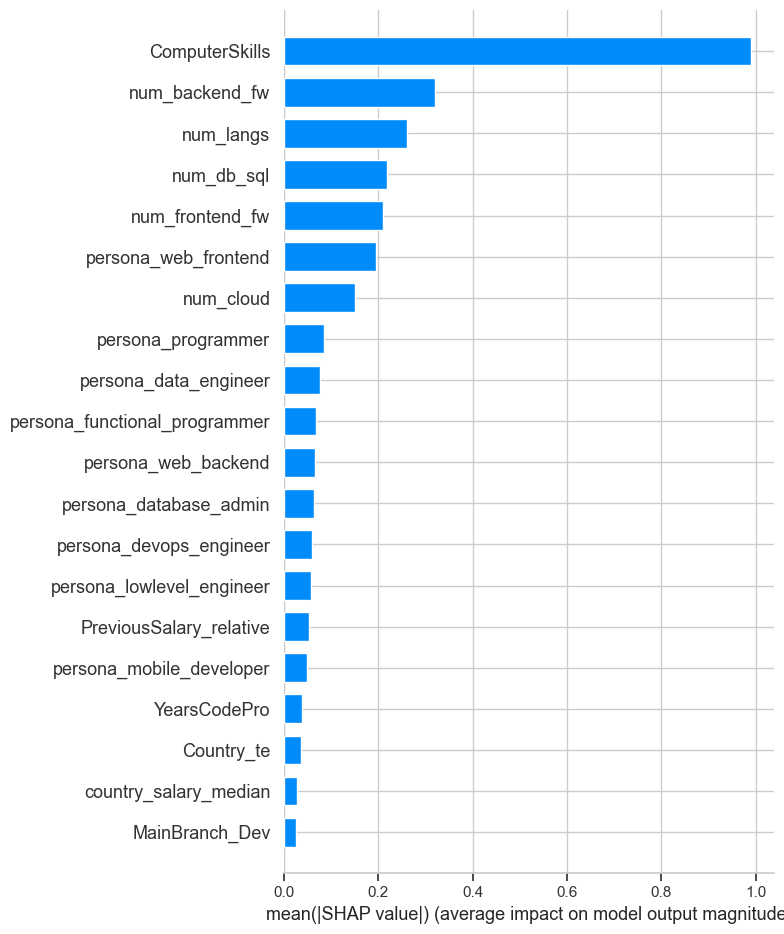


SHAP SUMMARY PLOT (BEESWARM)


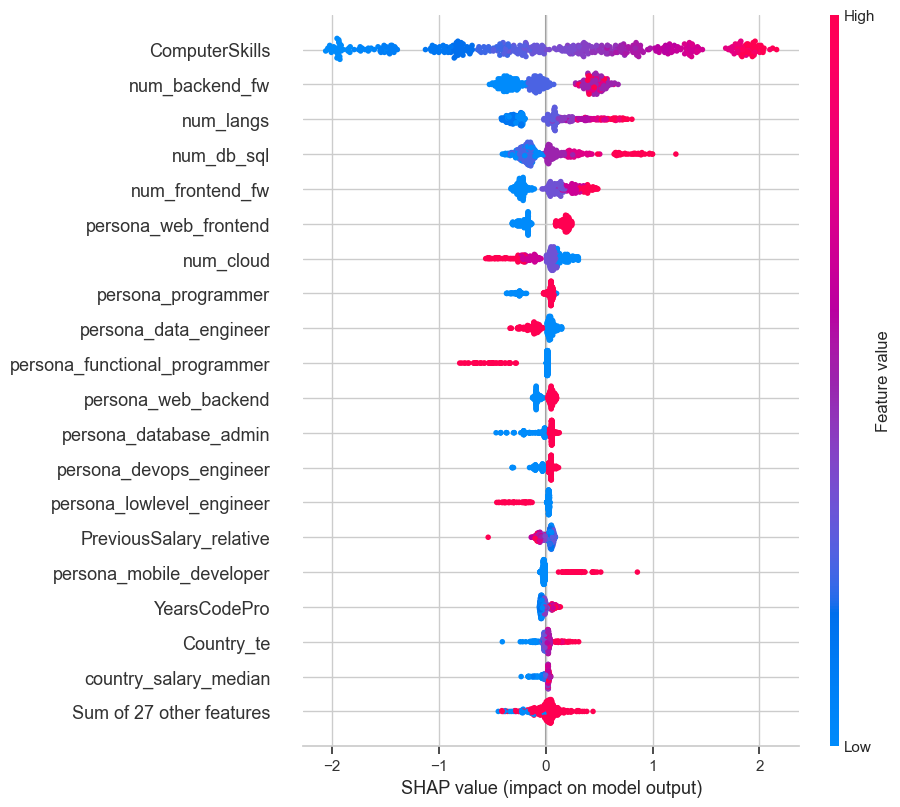


SHAP DEPENDENCE PLOT
Top feature (by mean |SHAP|): ComputerSkills



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

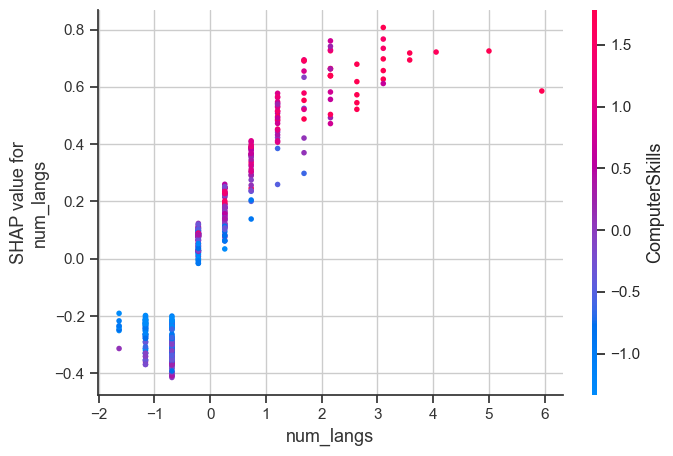

<Figure size 640x480 with 0 Axes>

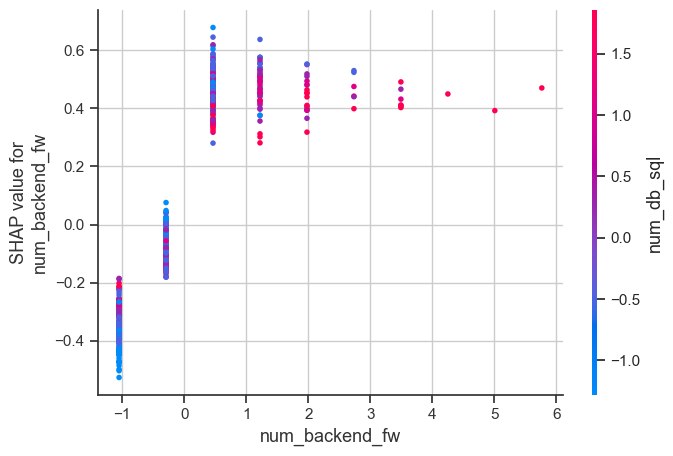

<Figure size 640x480 with 0 Axes>

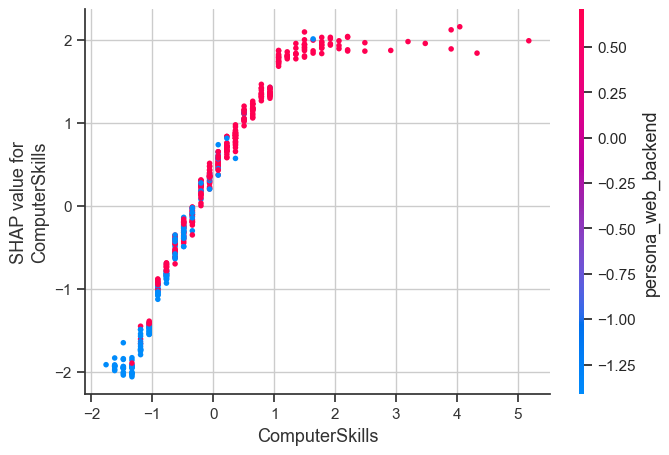


SHAP FORCE & WATERFALL (LOCAL)

Instance 0: true label = 1


<Figure size 640x480 with 0 Axes>

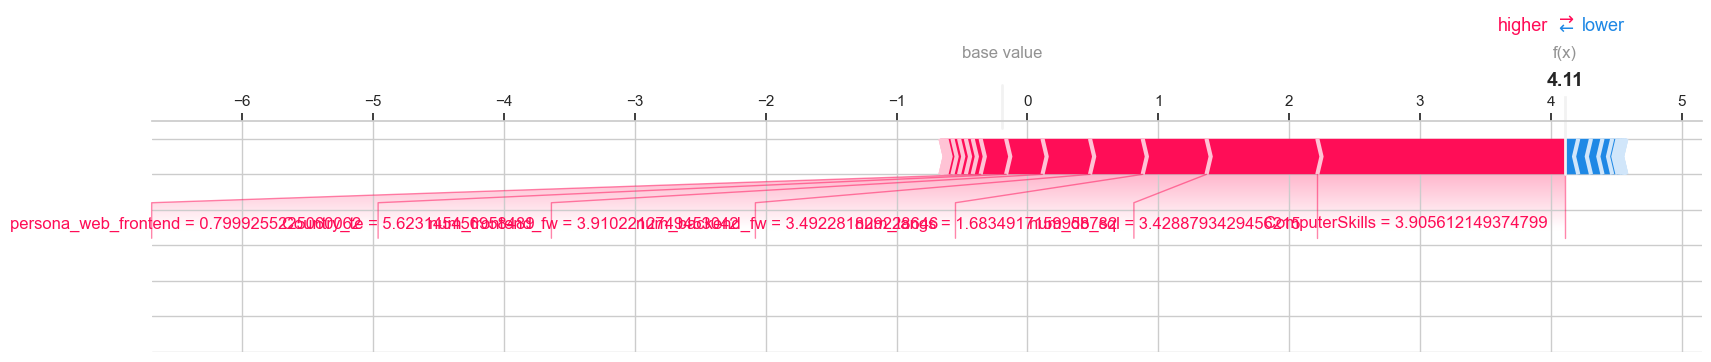

<Figure size 640x480 with 0 Axes>

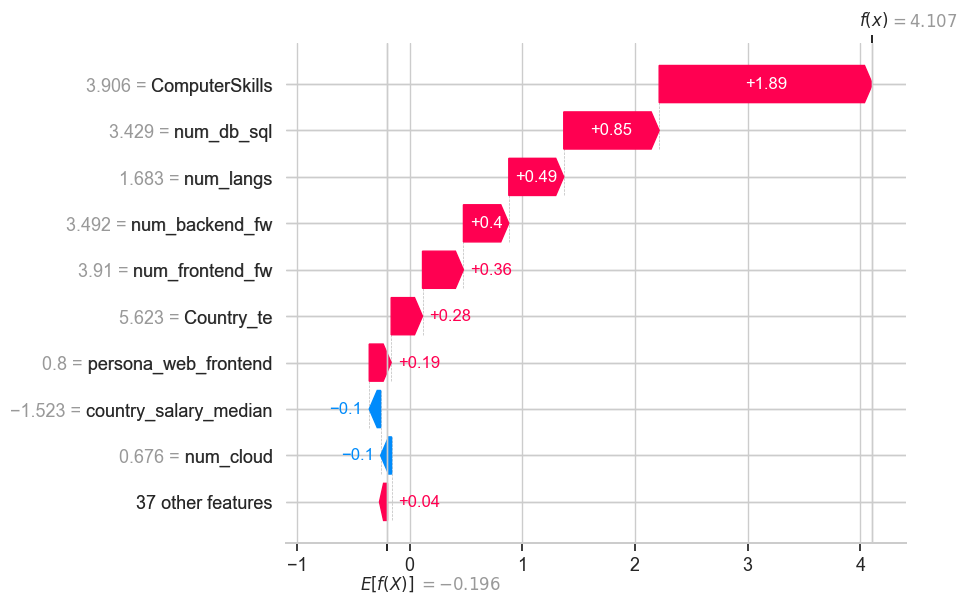

<Figure size 640x480 with 0 Axes>


Instance 1: true label = 1


<Figure size 640x480 with 0 Axes>

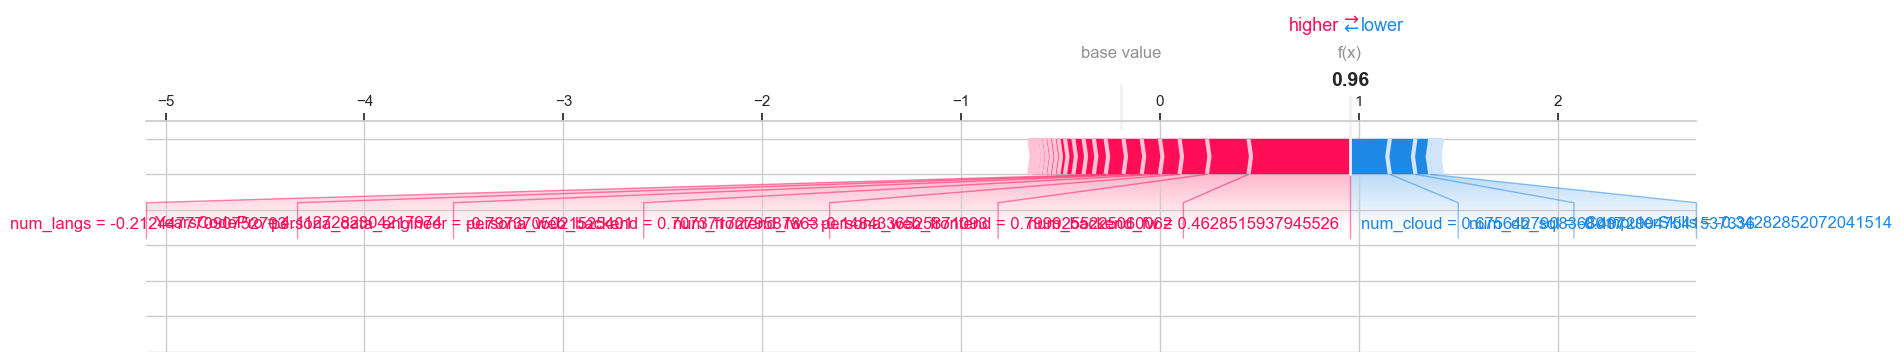

<Figure size 640x480 with 0 Axes>

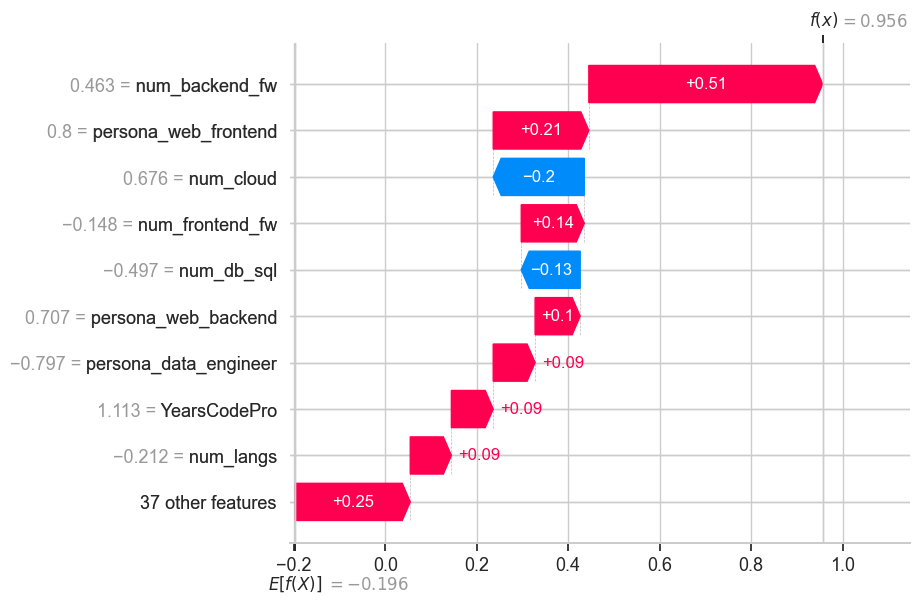

<Figure size 640x480 with 0 Axes>


MODEL-BASED FEATURE IMPORTANCE
Using tree-based feature importances...

Top 20 Features by Importance:
                          feature  importance
24                 ComputerSkills    0.758521
28                 num_backend_fw    0.054935
34           persona_web_frontend    0.041798
27                num_frontend_fw    0.026693
26                      num_langs    0.026001
29                     num_db_sql    0.018801
31                      num_cloud    0.017421
42  persona_functional_programmer    0.009331
35            persona_web_backend    0.007599
33             persona_programmer    0.006449
37          persona_data_engineer    0.006096
39       persona_mobile_developer    0.003787
43      persona_lowlevel_engineer    0.002567
38        persona_devops_engineer    0.002488
23                     Country_te    0.002295
3         PreviousSalary_relative    0.002113
7                    YearsCodePro    0.001667
41         persona_cloud_engineer    0.001352
36           persona_d

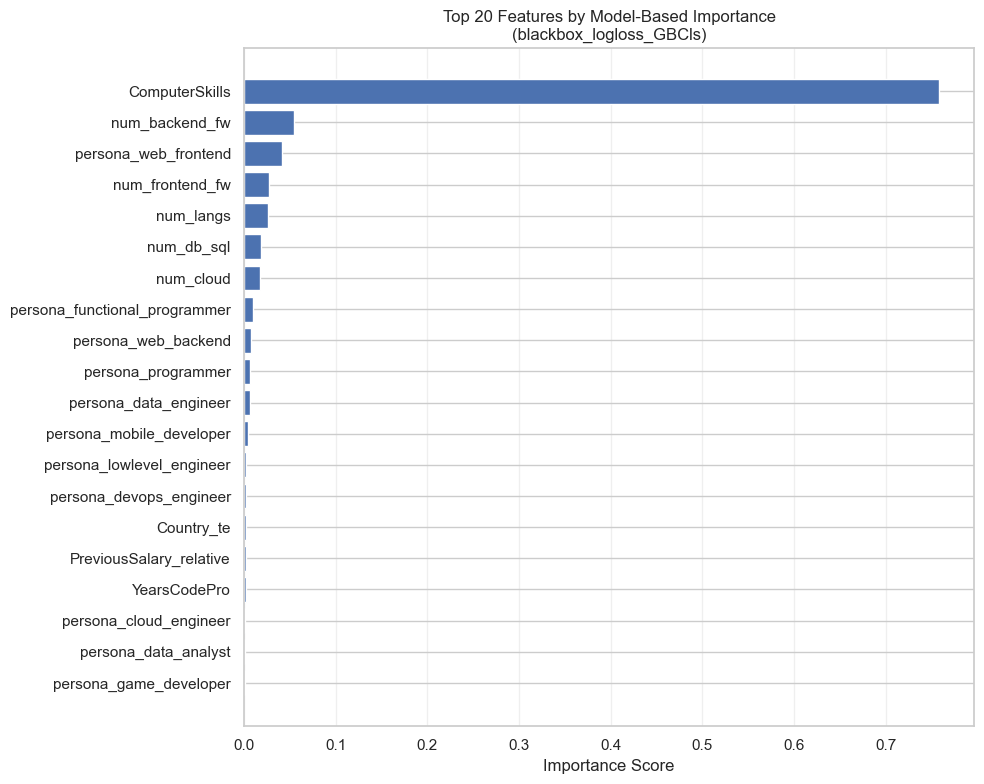


LIME ANALYSIS (LOCAL INTERPRETABILITY)
✓ LIME Explainer created with 44039 training samples


LIME Explanation for Test Instance 0
------------------------------------------------------------
Prediction: Not Employed
Probability (Employed): 0.3837

Top 15 Contributing Features (feature, weight):
  num_langs <= -0.69: -0.1240
  persona_functional_programmer <= -0.32: 0.1142
  num_db_sql > 0.29: 0.0936
  persona_mobile_developer <= -0.34: -0.0728
  -0.77 < ComputerSkills <= -0.06: -0.0724
  -1.05 < num_backend_fw <= -0.29: -0.0670
  persona_data_analyst <= -0.23: 0.0650
  persona_lowlevel_engineer <= -0.37: 0.0514
  persona_data_engineer <= -0.80: 0.0458
  Continent_Oceania <= -0.17: 0.0431
  persona_game_developer <= -0.24: -0.0373
  num_cloud <= -1.09: 0.0268
  -0.96 < num_frontend_fw <= -0.15: -0.0232
  country_salary_median <= -0.77: -0.0185
  Country_te > 0.25: 0.0156


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


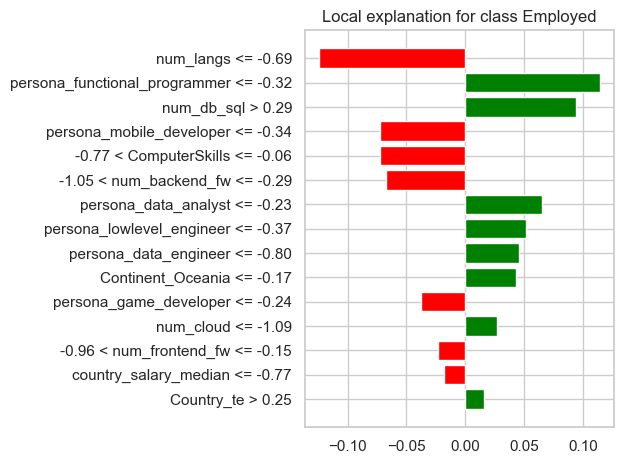


LIME Explanation for Test Instance 1
------------------------------------------------------------
Prediction: Employed
Probability (Employed): 0.9839


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



Top 15 Contributing Features (feature, weight):
  ComputerSkills > 0.51: 0.3168
  persona_functional_programmer <= -0.32: 0.1199
  num_langs > 0.26: 0.0987
  num_db_sql > 0.29: 0.0930
  num_backend_fw > 0.46: 0.0890
  persona_mobile_developer > -0.34: 0.0732
  persona_lowlevel_engineer <= -0.37: 0.0677
  persona_data_analyst <= -0.23: 0.0546
  persona_data_engineer <= -0.80: 0.0537
  persona_game_developer <= -0.24: -0.0483
  num_frontend_fw > 0.66: 0.0398
  num_cloud <= -1.09: 0.0391
  Country_te <= -0.41: -0.0230
  Continent_South America <= -0.26: -0.0187
  YearsCode > 0.61: 0.0164


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


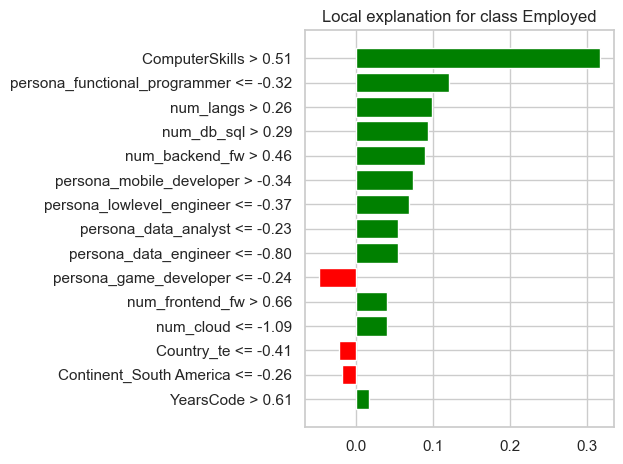


LIME Explanation for Test Instance 2
------------------------------------------------------------
Prediction: Employed
Probability (Employed): 0.8821


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



Top 15 Contributing Features (feature, weight):
  -0.06 < ComputerSkills <= 0.51: 0.1255
  persona_functional_programmer <= -0.32: 0.1034
  -0.29 < num_backend_fw <= 0.46: 0.0836
  persona_mobile_developer <= -0.34: -0.0751
  persona_data_analyst <= -0.23: 0.0620
  persona_lowlevel_engineer <= -0.37: 0.0618
  persona_game_developer <= -0.24: -0.0552
  persona_data_engineer <= -0.80: 0.0478
  num_db_sql <= -0.50: -0.0460
  num_frontend_fw > 0.66: 0.0396
  Continent_Oceania <= -0.17: -0.0316
  -0.21 < num_cloud <= 0.68: -0.0286
  PreviousSalary_relative <= -0.48: 0.0205
  -0.58 < Continent_North America <= 1.71: 0.0165
  Continent_Africa <= -0.17: 0.0138


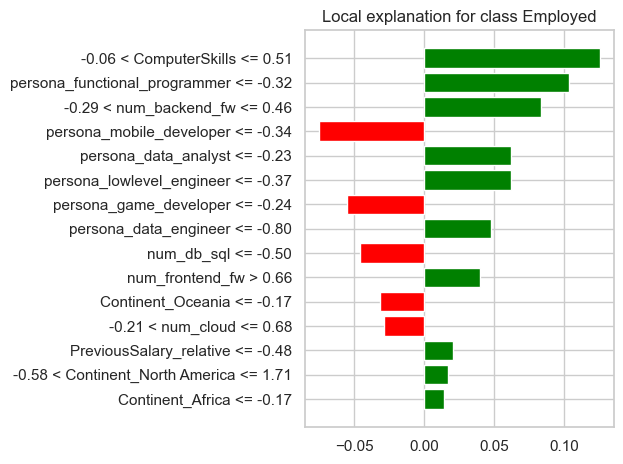


✓ SHAP & LIME ANALYSIS COMPLETE


In [9]:
# =====================================
# SHAP & LIME ANALYSIS (Complete Setup)
# =====================================

import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from scipy.special import expit

print("=" * 80)
print("SHAP & LIME ANALYSIS")
print("=" * 80)

best_model       = results["best_model"]
best_model_name  = results["best_model_name"]
preprocessor     = results["preprocessor"]
X_train_proc     = results["X_train_proc"]
X_valid_proc     = results["X_valid_proc"]
X_test_proc      = results["X_test_proc"]

print(f"Best model: {best_model_name}")
print(f"Model type: {type(best_model)}")
print(f"Processed data shape: {X_train_proc.shape}\n")

# =====================================
# 1. GET FEATURE NAMES
# =====================================

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = np.array([f"feature_{i}" for i in range(X_train_proc.shape[1])])

print(f"Number of features: {len(feature_names)}\n")

# =====================================
# 2. PREPARE DENSE MATRICES
# =====================================

if hasattr(X_train_proc, "toarray"):
    X_train_dense = X_train_proc.toarray()
    X_valid_dense = X_valid_proc.toarray()
    X_test_dense  = X_test_proc.toarray()
else:
    X_train_dense = X_train_proc.values if hasattr(X_train_proc, "values") else X_train_proc
    X_valid_dense = X_valid_proc.values if hasattr(X_valid_proc, "values") else X_valid_proc
    X_test_dense  = X_test_proc.values if hasattr(X_test_proc, "values") else X_test_proc

print(f"Dense data shapes - Train: {X_train_dense.shape}, Valid: {X_valid_dense.shape}, Test: {X_test_dense.shape}\n")

# =====================================
# 3. SHAP EXPLAINER
# =====================================

print("Creating SHAP Explainer...")

shap_sample_size = min(500, X_train_dense.shape[0])
background_idx = np.random.choice(X_train_dense.shape[0], shap_sample_size, replace=False)
X_background = X_train_dense[background_idx]

model_type = None

if isinstance(best_model, (GradientBoostingClassifier, GradientBoostingRegressor)):
    print("✓ Using TreeExplainer (Gradient Boosting detected)")
    explainer = shap.TreeExplainer(best_model, X_background)
    model_type = "tree"
elif isinstance(best_model, (LogisticRegression, RidgeClassifier)):
    print("✓ Using LinearExplainer (Linear model detected)")
    explainer = shap.LinearExplainer(best_model, X_background)
    model_type = "linear"
else:
    print("✓ Using KernelExplainer (Generic model)")
    def shap_predict_fn(x):
        if hasattr(best_model, "predict_proba"):
            return best_model.predict_proba(x)[:, 1]
        elif hasattr(best_model, "decision_function"):
            scores = best_model.decision_function(x)
            scores = np.atleast_1d(scores).reshape(-1)
            return expit(scores)
        else:
            preds = best_model.predict(x).reshape(-1)
            return preds
    explainer = shap.KernelExplainer(shap_predict_fn, X_background)
    model_type = "kernel"

print(f"Model type for SHAP: {model_type}\n")

# =====================================
# 4. COMPUTE SHAP VALUES
# =====================================

print("Computing SHAP values on validation set...")

shap_eval_size = min(500, X_valid_dense.shape[0])
X_shap = X_valid_dense[:shap_eval_size]
y_shap = y_valid[:shap_eval_size]

shap_values = explainer.shap_values(X_shap)

if isinstance(shap_values, list) and len(shap_values) == 2:
    print("Binary classification detected - using positive class SHAP values")
    shap_values = shap_values[1]

shap_values = np.array(shap_values)
print(f"✓ SHAP values shape: {shap_values.shape}\n")

shap.initjs()

# =====================================
# 5. SHAP SUMMARY PLOTS
# =====================================

print("=" * 80)
print("SHAP SUMMARY PLOT (BAR)")
print("=" * 80)

plt.figure()
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

print("\n" + "=" * 80)
print("SHAP SUMMARY PLOT (BEESWARM)")
print("=" * 80)

# Build a SHAP Explanation object explicitly
explanation = shap.Explanation(
    values=shap_values,              # (500, 41)
    base_values=explainer.expected_value,
    data=X_shap,                     # same shape as shap_values
    feature_names=list(feature_names)
)

# 1) Beeswarm (global + local)
shap.plots.beeswarm(explanation, max_display=20)
plt.show()



# =====================================
# 6. SHAP DEPENDENCE PLOTS
# =====================================

print("\n" + "=" * 80)
print("SHAP DEPENDENCE PLOT")
print("=" * 80)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_feature_idx = np.argsort(mean_abs_shap)[-1]
top_feature_name = feature_names[top_feature_idx]
print(f"Top feature (by mean |SHAP|): {top_feature_name}\n")

plt.figure()
shap.dependence_plot(
    top_feature_idx,
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index=None,
    show=True
)

top_3_indices = np.argsort(mean_abs_shap)[-3:]
for idx in top_3_indices:
    plt.figure()
    shap.dependence_plot(
        idx,
        shap_values,
        X_shap,
        feature_names=feature_names,
        show=True
    )

# =====================================
# 7. SHAP FORCE & WATERFALL (LOCAL)
# =====================================

print("\n" + "=" * 80)
print("SHAP FORCE & WATERFALL (LOCAL)")
print("=" * 80)

for sample_idx in [0, 1]:
    if sample_idx >= len(X_shap):
        break

    print(f"\nInstance {sample_idx}: true label = {y_shap.iloc[sample_idx] if hasattr(y_shap, 'iloc') else y_shap[sample_idx]}")

    if isinstance(explainer.expected_value, (list, np.ndarray)):
        if len(np.atleast_1d(explainer.expected_value)) > 1:
            base_value = explainer.expected_value[1]
        else:
            base_value = float(np.atleast_1d(explainer.expected_value)[0])
    else:
        base_value = float(explainer.expected_value)

    plt.figure()
    shap.force_plot(
        base_value,
        shap_values[sample_idx, :],
        X_shap[sample_idx, :],
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )
    plt.tight_layout()
    plt.show()

    plt.figure()
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[sample_idx, :],
        base_values=base_value,
        data=X_shap[sample_idx, :],
        feature_names=feature_names
    ), show=True)
    plt.tight_layout()
    plt.show()

# =====================================
# 8. MODEL-BASED FEATURE IMPORTANCE
# =====================================

print("\n" + "=" * 80)
print("MODEL-BASED FEATURE IMPORTANCE")
print("=" * 80)

importances = None

if hasattr(best_model, "feature_importances_"):
    print("Using tree-based feature importances...")
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    print("Using linear model coefficients (absolute value)...")
    coefs = best_model.coef_
    if coefs.ndim > 1:
        coefs = coefs[0]
    importances = np.abs(coefs)
else:
    print("⚠ Model does not expose feature_importances_ or coef_")

if importances is not None:
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("\nTop 20 Features by Importance:")
    print(fi_df.head(20).to_string())

    top_n = 20
    fi_top = fi_df.head(top_n)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(fi_top)), fi_top["importance"].values)
    plt.yticks(range(len(fi_top)), fi_top["feature"].values)
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_n} Features by Model-Based Importance\n({best_model_name})")
    plt.gca().invert_yaxis()
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

# =====================================
# 9. LIME ANALYSIS (LOCAL EXPLAINABILITY)
# =====================================

print("\n" + "=" * 80)
print("LIME ANALYSIS (LOCAL INTERPRETABILITY)")
print("=" * 80)

def model_predict_proba(X):
    X = np.asarray(X)
    if hasattr(best_model, "predict_proba"):
        return best_model.predict_proba(X)
    if hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X)
        scores = np.atleast_1d(scores).reshape(-1)
        probs_pos = expit(scores)
        probs_pos = np.clip(probs_pos, 1e-6, 1-1e-6)
        probs = np.vstack([1 - probs_pos, probs_pos]).T
        return probs
    preds = best_model.predict(X).reshape(-1)
    probs_pos = np.clip(preds, 1e-6, 1-1e-6)
    probs = np.vstack([1 - probs_pos, probs_pos]).T
    return probs

lime_explainer = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=feature_names.tolist(),
    class_names=["Not Employed", "Employed"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

print(f"✓ LIME Explainer created with {X_train_dense.shape[0]} training samples\n")

for sample_idx in [0, 1, 2]:
    if sample_idx >= X_test_dense.shape[0]:
        break

    print(f"\nLIME Explanation for Test Instance {sample_idx}")
    print("-" * 60)

    pred_proba = model_predict_proba(X_test_dense[sample_idx:sample_idx+1])[0]
    pred_label = np.argmax(pred_proba)

    print(f"Prediction: {['Not Employed', 'Employed'][pred_label]}")
    print(f"Probability (Employed): {pred_proba[1]:.4f}")

    exp = lime_explainer.explain_instance(
        X_test_dense[sample_idx],
        model_predict_proba,
        num_features=15
    )

    print("\nTop 15 Contributing Features (feature, weight):")
    for feat, weight in exp.as_list():
        print(f"  {feat}: {weight:.4f}")

    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("✓ SHAP & LIME ANALYSIS COMPLETE")
print("=" * 80)


Retraining the Model with Top Skills:

The above SHAP plots show that the model cares much more about **how many and which skills a person has** than about the broad persona labels. Count-type features such as `num_backend_fw`, `num_langs`, `num_db_sql`, `num_frontend_fw`, and `num_cloud` have the largest SHAP values, while persona flags (e.g. `persona_programmer`, `persona_data_engineer`, `persona_web_backend`) have much smaller impact and stay close to zero.

This makes sense because each persona is just a **0/1 summary** of several underlying skills, so it throws away detail that the model finds useful. Therefore, in the next step we include **Top-20 individual skills (by frequency) as separate features** and re-train the model to see if performance improves and how important these specific skills are compared to the persona features.


In [10]:
# =====================================
# 2. Skill sets & country mapping
# =====================================

LANGS = {
    "APL", "Assembly",
    "C", "C#", "C++",
    "COBOL", "Crystal", "Dart", "Delphi",
    "Elixir", "Erlang",
    "F#", "Fortran",
    "Go", "Groovy",
    "Haskell",
    "Java", "JavaScript", "TypeScript",
    "Julia",
    "Kotlin",
    "LISP", "Lua",
    "MATLAB", "Matlab",
    "OCaml",
    "Objective-C",
    "Perl", "PHP", "Python",
    "R", "Ruby", "Rust",
    "SAS", "Scala", "Solidity",
    "Swift",
    "VBA"
}

WEB_CORE = {"HTML/CSS", "JavaScript", "TypeScript"}

FRONTEND_FW = {
    "React.js", "Vue.js", "Angular", "Angular.js",
    "Svelte", "jQuery",
    "Next.js", "Nuxt.js", "Gatsby", "Blazor", "Flow"
}

BACKEND_FW = {
    "Node.js", "Express", "Deno",
    "Django", "Flask", "FastAPI", "Fastify",
    "Laravel", "Ruby on Rails", "Spring", "Symfony",
    "Phoenix", "Play Framework",
    "ASP.NET", "ASP.NET Core",
    "Drupal"
}

DB_SQL = {
    "MySQL", "PostgreSQL", "SQLite",
    "Microsoft SQL Server", "MariaDB",
    "Oracle", "IBM DB2"
}

DB_NOSQL = {
    "MongoDB", "Cassandra", "CouchDB", "Couchbase",
    "DynamoDB", "Redis", "Neo4j",
    "Firebase", "Firebase Realtime Database", "Cloud Firestore",
    "Elasticsearch"
}

DB_ANY = DB_SQL | DB_NOSQL
SQL_TECH = DB_SQL | {"SQL"}

CLOUD_PROVIDERS = {
    "AWS",
    "Google Cloud", "Google Cloud Platform",
    "Microsoft Azure",
    "IBM Cloud or Watson",
    "Oracle Cloud Infrastructure",
    "DigitalOcean", "Linode", "OVH",
    "Heroku", "Managed Hosting", "Colocation",
    "OpenStack", "VMware"
}

DEVOPS_TOOLS = {
    "Docker", "Kubernetes",
    "Terraform", "Pulumi",
    "Ansible", "Chef", "Puppet",
    "Bash/Shell", "PowerShell",
    "Homebrew", "Yarn", "npm", "Git"
}

DATA_LANGS = {"Python", "R", "SAS", "MATLAB", "Matlab"}
MOBILE_TOOLS = {"Swift", "Kotlin", "Xamarin"}
MOBILE_LANGS = {"Java", "C#", "Dart"}
GAME_ENGINES = {"Unity 3D", "Unreal Engine"}
GAME_LANGS = {"C#", "C++", "C"}
FUNCTIONAL_LANGS = {"Haskell", "Scala", "Clojure", "F#", "OCaml", "Elixir", "Erlang", "LISP"}
LOWLEVEL = {"C", "C++", "Rust", "Fortran", "COBOL", "Assembly"}
SCRIPTING = {"Bash/Shell", "PowerShell", "VBA"}
LEGACY_STACK = {"COBOL", "Fortran", "IBM DB2", "Oracle", "SAS", "VBA", "IBM Cloud or Watson"}

country_to_continent = {
    # Europe
    'Sweden': 'Europe', 'Spain': 'Europe', 'Germany': 'Europe', 'France': 'Europe',
    'Switzerland': 'Europe', 'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'Russian Federation': 'Europe', 'Italy': 'Europe', 'Netherlands': 'Europe',
    'Poland': 'Europe', 'Hungary': 'Europe', 'Bulgaria': 'Europe', 'Greece': 'Europe',
    'Romania': 'Europe', 'Lithuania': 'Europe', 'Ukraine': 'Europe', 'Croatia': 'Europe',
    'Georgia': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe', 'Portugal': 'Europe',
    'Slovakia': 'Europe', 'Armenia': 'Europe', 'Finland': 'Europe', 'Belgium': 'Europe',
    'Austria': 'Europe', 'Norway': 'Europe', 'Serbia': 'Europe', 'Malta': 'Europe',
    'Czech Republic': 'Europe', 'Belarus': 'Europe', 'Slovenia': 'Europe',
    'The former Yugoslav Republic of Macedonia': 'Europe', 'Cyprus': 'Europe',
    'Luxembourg': 'Europe', 'Iceland': 'Europe', 'Bosnia and Herzegovina': 'Europe',
    'Estonia': 'Europe', 'Latvia': 'Europe', 'Kosovo': 'Europe', 'Andorra': 'Europe',
    'Montenegro': 'Europe', 'Monaco': 'Europe', 'Isle of Man': 'Europe', 'Republic of Moldova': 'Europe',

    # Asia
    'Singapore': 'Asia', 'Israel': 'Asia', 'Turkey': 'Asia', 'Pakistan': 'Asia',
    'Bangladesh': 'Asia', 'Viet Nam': 'Asia', 'India': 'Asia', 'Lebanon': 'Asia',
    'Bahrain': 'Asia', 'Iran, Islamic Republic of...': 'Asia', 'Hong Kong (S.A.R.)': 'Asia',
    'Japan': 'Asia', 'United Arab Emirates': 'Asia', 'Malaysia': 'Asia', 'China': 'Asia',
    'Taiwan': 'Asia', 'South Korea': 'Asia', 'Nepal': 'Asia', 'Kazakhstan': 'Asia',
    'Uzbekistan': 'Asia', 'Syrian Arab Republic': 'Asia', 'Jordan': 'Asia',
    'Saudi Arabia': 'Asia', 'Thailand': 'Asia', 'Azerbaijan': 'Asia',
    'Iraq': 'Asia', 'Kuwait': 'Asia', 'Myanmar': 'Asia', 'Republic of Korea': 'Asia',
    'Cambodia': 'Asia', 'Kyrgyzstan': 'Asia', 'Afghanistan': 'Asia', 'Turkmenistan': 'Asia',
    'Palestine': 'Asia', 'Tajikistan': 'Asia', 'Oman': 'Asia', 'Maldives': 'Asia',
    'Qatar': 'Asia', 'Mongolia': 'Asia', 'Bhutan': 'Asia', 'Timor-Leste': 'Asia', 'Sri Lanka': 'Asia',
    'Indonesia': 'Asia', "Lao People's Democratic Republic": 'Asia', 'Philippines': 'Asia',
    'Yemen': 'Asia',

    # Africa
    'Nigeria': 'Africa', 'Albania': 'Europe', 'Egypt': 'Africa', 'South Africa': 'Africa',
    'Madagascar': 'Africa', 'Kenya': 'Africa', 'Botswana': 'Africa', 'Algeria': 'Africa',
    'Ethiopia': 'Africa', 'Zambia': 'Africa', 'Tunisia': 'Africa', 'Cameroon': 'Africa',
    'Somalia': 'Africa', 'Angola': 'Africa', 'United Republic of Tanzania': 'Africa',
    'Mozambique': 'Africa', 'Ghana': 'Africa', 'Congo, Republic of the...': 'Africa',
    'Democratic Republic of the Congo': 'Africa', 'Uganda': 'Africa', 'Swaziland': 'Africa',
    'Rwanda': 'Africa', 'Sudan': 'Africa', 'Libyan Arab Jamahiriya': 'Africa',
    'Zimbabwe': 'Africa', 'Mauritius': 'Africa', 'Namibia': 'Africa', 'Togo': 'Africa',
    'Lesotho': 'Africa', 'Guinea': 'Africa', 'Senegal': 'Africa', 'Liberia': 'Africa',
    'Niger': 'Africa', 'Djibouti': 'Africa', 'Malawi': 'Africa', 'Gambia': 'Africa',
    'Burkina Faso': 'Africa', 'Mauritania': 'Africa', 'Burundi': 'Africa', 'Mali': 'Africa',
    'Benin': 'Africa', "Côte d'Ivoire": 'Africa', 'Cape Verde': 'Africa', 'Seychelles': 'Africa', 'Morocco': 'Africa',
    "CÃ´te d'Ivoire": 'Africa',

    # North America
    'Canada': 'North America', 'United States of America': 'North America', 'Mexico': 'North America',
    'Costa Rica': 'North America', 'Cuba': 'North America', 'Dominican Republic': 'North America',
    'Guatemala': 'North America', 'Honduras': 'North America', 'El Salvador': 'North America',
    'Panama': 'North America', 'Nicaragua': 'North America', 'Haiti': 'North America',
    'Belize': 'North America', 'Jamaica': 'North America',

    # South America
    'Brazil': 'South America', 'Colombia': 'South America', 'Chile': 'South America',
    'Argentina': 'South America', 'Peru': 'South America', 'Bolivia': 'South America',
    'Venezuela, Bolivarian Republic of...': 'South America', 'Ecuador': 'South America',
    'Paraguay': 'South America', 'Uruguay': 'South America', 'Guyana': 'South America',
    'Suriname': 'South America', 'Venezuela, Bolivarian Republic ofÉ': 'South America',

    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania', 'Fiji': 'Oceania',

    # Caribbean (included under North America here)
    'Trinidad and Tobago': 'North America', 'Barbados': 'North America', 'Dominica': 'North America',
    'Saint Kitts and Nevis': 'North America', 'Saint Lucia': 'North America',
    'Saint Vincent and the Grenadines': 'North America',

    # Other
    'Nomadic': 'Other',
}

def country_to_continent_fn(country):
    if pd.isna(country):
        return "Other"
    return country_to_continent.get(country, "Other")

# =====================================
# 3. Helpers
# =====================================

def parse_skills(raw):
    if pd.isna(raw):
        return []
    if isinstance(raw, (list, tuple, set)):
        parts = [str(s).strip() for s in raw]
    else:
        parts = [s.strip() for s in str(raw).split(";")]
    return [p for p in parts if p]

def safe_years_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s_low = s.lower()
    if s_low in ("less than 1 year", "<1", "< 1", "0"):
        return 0.5
    if s_low.startswith("more than"):
        try:
            n = float(s.split()[-2])
            return n
        except Exception:
            return 50.0
    try:
        return float(s)
    except Exception:
        m = re.search(r"\d+(\.\d+)?", s)
        if m:
            return float(m.group(0))
        return np.nan

def persona_feature_dict(skills_list):
    """
    Build skill-count features + persona flags from a list of skills.

    Personas (all derived ONLY from the given skill sets):
      - programmer
      - web_frontend
      - web_backend
      - data_analyst
      - data_engineer
      - devops_engineer
      - mobile_developer
      - legacy_enterprise_dev
      - cloud_engineer
      - functional_programmer
      - lowlevel_engineer
      - game_developer
      - database_admin
    """
    skills = set(skills_list)

    # --- Group intersections (for reuse) ---
    langs         = skills & LANGS
    web_core      = skills & WEB_CORE
    fe_fw         = skills & FRONTEND_FW
    be_fw         = skills & BACKEND_FW
    db_sql        = skills & DB_SQL
    db_nosql      = skills & DB_NOSQL
    db_any        = db_sql | db_nosql
    cloud         = skills & CLOUD_PROVIDERS
    devops        = skills & DEVOPS_TOOLS
    data_langs    = skills & DATA_LANGS
    mobile_tools  = skills & MOBILE_TOOLS
    mobile_langs  = skills & MOBILE_LANGS
    game_engines  = skills & GAME_ENGINES
    game_langs    = skills & GAME_LANGS
    functional    = skills & FUNCTIONAL_LANGS
    lowlevel      = skills & LOWLEVEL
    scripting     = skills & SCRIPTING
    legacy        = skills & LEGACY_STACK

    # --- Helper sets (all built from your skills only) ---
    CORE_PROG_LANGS      = {"C", "C++", "Java", "C#", "Go", "Rust",
                            "Kotlin", "Scala", "Swift", "Dart",
                            "TypeScript", "JavaScript", "Python",
                            "Ruby", "PHP"}
    BACKEND_LANGS        = {"JavaScript", "TypeScript", "Java", "C#",
                            "PHP", "Python", "Ruby", "Go", "Kotlin",
                            "Dart", "Scala"}
    ANALYST_LANGS        = {"R", "SAS", "MATLAB", "Matlab"}
    DATA_ENGINEER_LANGS  = {"Python", "Scala", "Java"}
    # SQL appears as a separate skill in your data
    has_sql_like         = (len(db_sql) > 0) or ("SQL" in skills)

    # =====================================================
    # Persona definitions (try to avoid noisy flags)
    # =====================================================

    # 1) General programmer:
    #    - Either: at least 2 core general-purpose langs
    #    - Or: at least 3 total languages from LANGS
    is_programmer = (len(langs & CORE_PROG_LANGS) >= 2) or (len(langs) >= 3)

    # 2) Web frontend:
    #    - At least 1 frontend framework
    #    - AND at least one web core tech (HTML/CSS, JS, TS)
    is_web_frontend = (len(fe_fw) >= 1) and (len(web_core) >= 1)

    # 3) Web backend:
    #    - At least 1 backend framework
    #    - AND at least one backend language
    #    - AND some database/SQL exposure
    is_web_backend = (
        (len(be_fw) >= 1) and
        (len(langs & BACKEND_LANGS) >= 1) and
        (len(db_any) >= 1 or "SQL" in skills)
    )

    # 4) Data analyst:
    #    - At least one "analyst" language (R, SAS, MATLAB)
    #    - AND SQL / relational DB exposure
    is_data_analyst = (
        (len(skills & ANALYST_LANGS) >= 1) and
        has_sql_like
    )

    # 5) Data engineer:
    #    - At least one data-engineer language (Python / Scala / Java)
    #    - AND at least one DB (SQL or NoSQL)
    #    - AND at least one cloud provider
    #    - AND at least one DevOps tool (Docker, Terraform, etc.)
    is_data_engineer = (
        (len(skills & DATA_ENGINEER_LANGS) >= 1) and
        (len(db_any) >= 1) and
        (len(cloud) >= 1) and
        (len(devops) >= 1)
    )

    # 6) DevOps engineer:
    #    - At least 2 DevOps tools
    #    - AND (cloud OR scripting) to suggest infra focus
    is_devops_engineer = (
        (len(devops) >= 2) and
        (len(cloud) >= 1 or len(scripting) >= 1)
    )

    # 7) Mobile developer:
    #    - At least one mobile tool (Swift/Kotlin/Xamarin)
    #    - AND at least one mobile language (Java, C#, Dart)
    is_mobile_developer = (
        (len(mobile_tools) >= 1) and
        (len(mobile_langs) >= 1)
    )

    # 8) Legacy enterprise developer:
    #    - Strong evidence via COBOL / Fortran / IBM DB2
    #    - OR at least 2 legacy stack items (SAS, Oracle, VBA, IBM Cloud...)
    is_legacy_enterprise_dev = (
        (len(legacy & {"COBOL", "Fortran", "IBM DB2"}) >= 1) or
        (len(legacy) >= 2)
    )

    # 9) Cloud engineer:
    #    - At least one cloud provider
    #    - AND some infra / automation signal (DevOps or scripting)
    is_cloud_engineer = (
        (len(cloud) >= 1) and
        (len(devops) >= 1 or len(scripting) >= 1)
    )

    # 10) Functional programmer:
    #     - At least one functional language (Haskell, Scala, Clojure, F#, OCaml, Elixir, Erlang, LISP)
    is_functional_programmer = (len(functional) >= 1)

    # 11) Low-level / systems engineer:
    #     - At least 2 low-level langs
    #       (C, C++, Rust, Fortran, COBOL, Assembly)
    is_lowlevel_engineer = (len(lowlevel) >= 2)

    # 12) Game developer:
    #     - A game engine (Unity 3D / Unreal Engine)
    #     - AND a game language (C#, C++, C)
    is_game_developer = (
        (len(game_engines) >= 1) and
        (len(game_langs) >= 1)
    )

    # 13) Database admin:
    #     - Either: 2+ SQL databases
    #     - OR: mix of SQL + NoSQL
    #     - OR: 3+ distinct database techs overall
    is_database_admin = (
        (len(db_sql) >= 2) or
        (len(db_sql) >= 1 and len(db_nosql) >= 1) or
        (len(db_any) >= 3)
    )

    # =====================================================
    # Output feature dict (counts + persona flags)
    # =====================================================
    out = {}

    # Counts (still useful numerical signals)
    # out["num_skills"]       = len(skills_list)
    out["num_langs"]        = len(langs)
    out["num_frontend_fw"]  = len(fe_fw)
    out["num_backend_fw"]   = len(be_fw)
    out["num_db_sql"]       = len(db_sql)
    out["num_db_nosql"]     = len(db_nosql)
    out["num_cloud"]        = len(cloud)
    out["num_devops"]       = len(devops)

    # Persona flags
    out["persona_programmer"]            = int(is_programmer)
    out["persona_web_frontend"]         = int(is_web_frontend)
    out["persona_web_backend"]          = int(is_web_backend)
    out["persona_data_analyst"]         = int(is_data_analyst)
    out["persona_data_engineer"]        = int(is_data_engineer)
    out["persona_devops_engineer"]      = int(is_devops_engineer)
    out["persona_mobile_developer"]     = int(is_mobile_developer)
    out["persona_legacy_enterprise_dev"]= int(is_legacy_enterprise_dev)
    out["persona_cloud_engineer"]       = int(is_cloud_engineer)
    out["persona_functional_programmer"]= int(is_functional_programmer)
    out["persona_lowlevel_engineer"]    = int(is_lowlevel_engineer)
    out["persona_game_developer"]       = int(is_game_developer)
    out["persona_database_admin"]       = int(is_database_admin)

    return out

# =====================================
# 4. EmploymentPreprocessor (fixed to expose feature names)
# =====================================

class EmploymentPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, country_target_encode=True, pca_on_skills=False, pca_components=5, random_state=42):
        self.country_target_encode = country_target_encode
        self.pca_on_skills = pca_on_skills
        self.pca_components = pca_components
        self.random_state = random_state

    def fit(self, X, y=None):
        X = X.copy()

        # ---------------------------
        # 1) EdLevel mapping + median
        # ---------------------------
        self.ed_map_ = {"High school":0, "Undergraduate":1, "Master":2, "PhD":3}
        ed_ord = X["EdLevel"].map(self.ed_map_).astype(float)
        self.ed_median_ = float(ed_ord.median(skipna=True)) if not ed_ord.isna().all() else 1.0

        # ---------------------------
        # 2) Country target encoding
        # ---------------------------
        if self.country_target_encode and y is not None:
            country_ser = X["Country"].fillna("Other").astype(str)
            dfc = pd.DataFrame({"country": country_ser.values, "y": pd.Series(y).values})
            self.country_mean_map_ = dfc.groupby("country")["y"].mean().to_dict()
            self.country_global_mean_ = float(pd.Series(y).mean())
        else:
            self.country_mean_map_, self.country_global_mean_ = {}, 0.0

        # ---------------------------
        # 3) Country salary medians
        # ---------------------------
        self.country_salary_median_ = X.groupby("Country")["PreviousSalary"].median().to_dict()

        # ---------------------------
        # 4) Top-20 skills (by frequency in TRAIN)
        # ---------------------------
        skill_lists_for_top = X["HaveWorkedWith"].apply(parse_skills)
        all_skills_counter = Counter([s for lst in skill_lists_for_top for s in lst])
        self.top_skills_ = [s for s, _ in all_skills_counter.most_common(20)]

        # ---------------------------
        # 5) Optional PCA on skills (unchanged)
        # ---------------------------
        if self.pca_on_skills:
            from collections import Counter as Cnt  # avoid shadowing
            skill_lists = X["HaveWorkedWith"].apply(parse_skills)
            all_sk = Cnt([s for lst in skill_lists for s in lst])
            top_sk = [s for s,_ in all_sk.most_common(200)]
            self.skill_vocab_ = top_sk
            M = np.zeros((len(skill_lists), len(top_sk)), dtype=float)
            for i, lst in enumerate(skill_lists):
                for s in lst:
                    if s in top_sk:
                        M[i, top_sk.index(s)] = 1.0
            self.pca_ = PCA(self.pca_components, random_state=self.random_state)
            if M.sum() > 0:
                self.pca_.fit(M)
            else:
                self.pca_ = None
        else:
            self.pca_ = None
            self.skill_vocab_ = None

        # ---------------------------
        # 6) Build features on TRAIN to fix column order
        # ---------------------------
        feat_df = self._make_features(X)
        self.feature_columns_ = list(feat_df.columns)
        self.feature_names_ = np.array(self.feature_columns_)

        # ---------------------------
        # 7) Fit imputer & scaler
        # ---------------------------
        self.num_imputer_ = SimpleImputer(strategy="median")
        self.num_imputer_.fit(feat_df.values)
        self.scaler_ = StandardScaler()
        self.scaler_.fit(self.num_imputer_.transform(feat_df.values))
        return self

    def _make_features(self, X):
        X = X.copy()
        out = pd.DataFrame(index=X.index)

        # ========== Salary ==========
        out["PreviousSalary"] = pd.to_numeric(X["PreviousSalary"], errors="coerce")
        out["PreviousSalary_log"] = np.log1p(out["PreviousSalary"])
        country = X["Country"].fillna("Other").astype(str)
        out["country_salary_median"] = [self.country_salary_median_.get(c, np.nan) for c in country]
        out["PreviousSalary_relative"] = out["PreviousSalary"] / (out["country_salary_median"] + 1e-9)

        # ========== Education ==========
        out["EdLevel_ord"] = X["EdLevel"].map(self.ed_map_).astype(float)
        out["EdLevel_is_other"] = X["EdLevel"].isin(["Other","Others"]).astype(int)
        out["EdLevel_ord"] = out["EdLevel_ord"].fillna(self.ed_median_)

        # ========== Experience ==========
        out["YearsCode"] = X["YearsCode"].apply(safe_years_to_float)
        out["YearsCodePro"] = X["YearsCodePro"].apply(safe_years_to_float)
        out["YearsCode"].fillna(out["YearsCode"].median(), inplace=True)
        out["YearsCodePro"].fillna(out["YearsCodePro"].median(), inplace=True)
        out["exp_gap"] = out["YearsCode"] - out["YearsCodePro"]
        out["exp_ratio"] = out["YearsCodePro"] / (out["YearsCode"] + 1e-6)

        # ========== Age & binaries ==========
        out["Age_lt35"] = (X["Age"] == "<35").astype(int)
        out["Accessibility_bin"] = X["Accessibility"].map({"Yes":1,"No":0}).fillna(0).astype(int)
        out["MentalHealth_bin"] = X["MentalHealth"].map({"Yes":1,"No":0}).fillna(0).astype(int)
        out["MainBranch_Dev"] = (X["MainBranch"] == "Dev").astype(int)
        out["is_Man"] = (X["Gender"] == "Man").astype(int)
        out["is_Woman"] = (X["Gender"] == "Woman").astype(int)

        # ========== Country / continent ==========
        out["Country_continent"] = X["Country"].apply(country_to_continent_fn)
        continent_dummies = pd.get_dummies(out["Country_continent"], prefix="Continent")
        out = pd.concat([out, continent_dummies], axis=1)
        out = out.drop(columns=["Country_continent"])

        if hasattr(self, "country_mean_map_") and self.country_target_encode:
            out["Country_te"] = X["Country"].fillna("Other").astype(str).map(self.country_mean_map_).fillna(self.country_global_mean_)
        else:
            out["Country_te"] = 0.0

        # keep raw ComputerSkills / Employment flags you added
        out["ComputerSkills"] = X["ComputerSkills"]
        out["PreviousEmployment"] = X["Employment"]

        # ========== Skills & personas ==========
        skill_lists = X["HaveWorkedWith"].apply(parse_skills)

        # --- persona features ---
        persona_rows = [persona_feature_dict(lst) for lst in skill_lists]
        persona_df = pd.DataFrame(persona_rows, index=X.index)
        out = pd.concat([out, persona_df], axis=1)

        # --- TOP-20 single-skill dummies (from TRAIN) ---
        if hasattr(self, "top_skills_") and self.top_skills_ is not None:
            for sk in self.top_skills_:
                # make a safe column name
                safe_name = re.sub(r"[^0-9a-zA-Z]+", "_", sk).strip("_")
                col_name = f"skill_{safe_name}"
                out[col_name] = skill_lists.apply(lambda L, s=sk: int(s in L))

        # ========== Optional PCA on skills ==========
        if self.pca_ is not None and self.skill_vocab_ is not None:
            vocab = self.skill_vocab_
            M = np.zeros((len(skill_lists), len(vocab)), dtype=float)
            for i, lst in enumerate(skill_lists):
                for s in lst:
                    if s in vocab:
                        j = vocab.index(s)
                        M[i, j] = 1.0
            comps = self.pca_.transform(M)
            comps_df = pd.DataFrame(
                comps, index=X.index,
                columns=[f"skill_pca_{i}" for i in range(comps.shape[1])]
            )
            out = pd.concat([out, comps_df], axis=1)

        return out

    def transform(self, X):
        feat_df = self._make_features(X)
        # align to train columns
        feat_df = feat_df.reindex(columns=self.feature_columns_, fill_value=np.nan)
        arr = self.num_imputer_.transform(feat_df.values)
        arr = self.scaler_.transform(arr)
        return pd.DataFrame(arr, index=feat_df.index, columns=self.feature_columns_)

    def get_feature_names_out(self):
        return np.array(self.feature_columns_)



Fitting preprocessor on training data...


/var/folders/zr/hq_q97d52l1ck8p_4myglv4r0000gn/T/ipykernel_7177/3591691926.py:491: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  out["YearsCode"].fillna(out["YearsCode"].median(), inplace=True)
/var/folders/zr/hq_q97d52l1ck8p_4myglv4r0000gn/T/ipykernel_7177/3591691926.py:492: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

Processed shapes - Train: (44039, 66), Valid: (14680, 66), Test: (14680, 66)

Defining models...

Training glassbox_L2_Ridge...


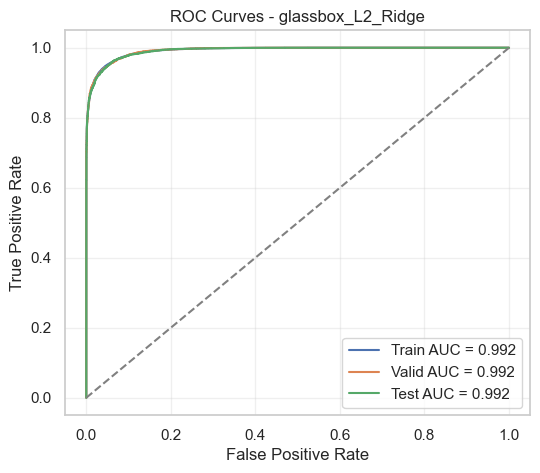

Training glassbox_logloss_LogReg...


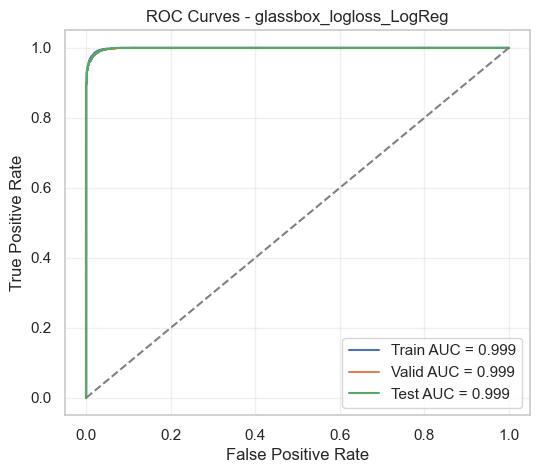

Training blackbox_L2_GBReg...


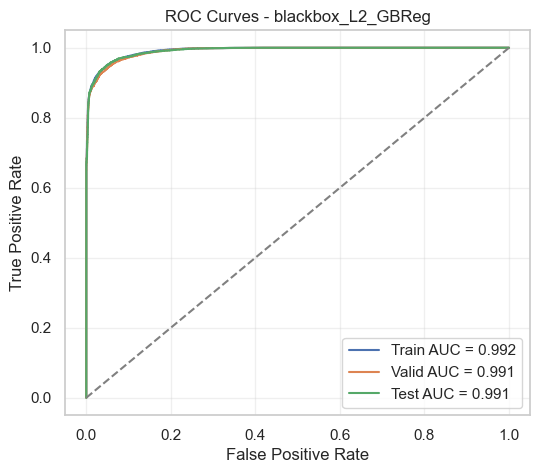

Training blackbox_logloss_GBCls...


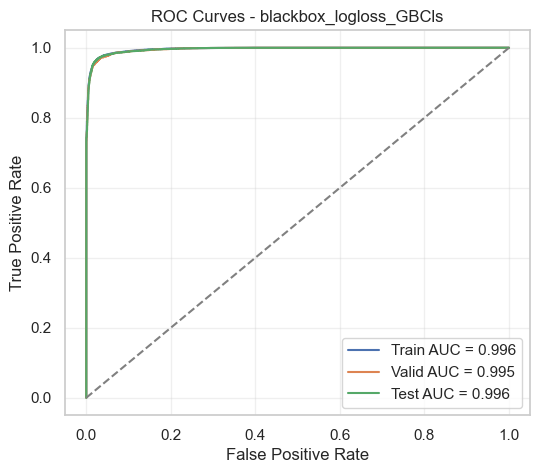


RESULTS SUMMARY (sorted by Validation AUC)
                model_name  auc_train  auc_valid  auc_test  best_threshold  eval_loss_valid  eval_loss_test
1  glassbox_logloss_LogReg   0.999039   0.998781  0.998849        0.185000            501.0           479.0
3   blackbox_logloss_GBCls   0.995880   0.995403  0.995555        0.396022           1040.0          1052.0
0        glassbox_L2_Ridge   0.991979   0.991981  0.991630       -0.195332           1345.0          1454.0
2        blackbox_L2_GBReg   0.991828   0.990754  0.991379        0.396757           1569.0          1540.0

✓ Best model selected: glassbox_logloss_LogReg
  - Validation AUC: 0.9988
  - Test AUC: 0.9988
  - Best threshold: 0.1850

FINAL TEST SET EVALUATION (Best Model)

Test AUC: 0.9988
Evaluation Loss (test): 479.00

Classification Report:
              precision    recall  f1-score   support

Not Employed       1.00      0.95      0.97      6802
    Employed       0.96      1.00      0.98      7878

    accuracy    

In [11]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from copy import deepcopy
import numpy as np
import pandas as pd
import re
from collections import Counter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def train_and_evaluate_employment_models(X_train, y_train, X_valid, y_valid, X_test, y_test):
    """
    Complete pipeline using EmploymentPreprocessor with multiple models.
    """
    print("Fitting preprocessor on training data...")
    preprocessor = EmploymentPreprocessor(
        country_target_encode=True,
        pca_on_skills=False,
        random_state=42
    )
    preprocessor.fit(X_train, y_train)

    # Transform splits
    X_train_proc = preprocessor.transform(X_train)
    X_valid_proc = preprocessor.transform(X_valid)
    X_test_proc  = preprocessor.transform(X_test)

    print(f"Processed shapes - Train: {X_train_proc.shape}, Valid: {X_valid_proc.shape}, Test: {X_test_proc.shape}\n")

    def get_scores_from_model(model, X):
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            return model.decision_function(X)
        else:
            return model.predict(X).astype(float)

    def evaluation_loss(y_true, y_pred, fp_cost=1.0, fn_cost=5.0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        fp = np.logical_and(y_true == 0, y_pred == 1).sum()
        fn = np.logical_and(y_true == 1, y_pred == 0).sum()
        return fp_cost * fp + fn_cost * fn

    def find_best_threshold(y_true, scores, fp_cost=1.0, fn_cost=5.0, n_steps=201):
        scores = np.asarray(scores)
        thr_grid = np.linspace(scores.min(), scores.max(), n_steps)
        best_thr, best_loss = None, np.inf
        for thr in thr_grid:
            y_pred = (scores >= thr).astype(int)
            loss = evaluation_loss(y_true, y_pred, fp_cost, fn_cost)
            if loss < best_loss:
                best_loss = loss
                best_thr = thr
        return best_thr, best_loss

    print("Defining models...\n")
    models = {
        "glassbox_L2_Ridge": RidgeClassifier(alpha=1.0, random_state=42),
        "glassbox_logloss_LogReg": LogisticRegression(
            penalty='l2', solver='liblinear', max_iter=1000, random_state=42
        ),
        "blackbox_L2_GBReg": GradientBoostingRegressor(
            loss='squared_error', n_estimators=200, learning_rate=0.05, 
            max_depth=3, random_state=42
        ),
        "blackbox_logloss_GBCls": GradientBoostingClassifier(
            loss='log_loss', n_estimators=200, learning_rate=0.05,
            max_depth=3, random_state=42
        ),
    }

    results = []
    trained_models = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        m = deepcopy(model)
        m.fit(X_train_proc, y_train)
        trained_models[model_name] = m

        scores_train = get_scores_from_model(m, X_train_proc)
        scores_valid = get_scores_from_model(m, X_valid_proc)
        scores_test  = get_scores_from_model(m, X_test_proc)

        auc_train = roc_auc_score(y_train, scores_train)
        auc_valid = roc_auc_score(y_valid, scores_valid)
        auc_test  = roc_auc_score(y_test,  scores_test)

        best_thr, best_loss_val = find_best_threshold(y_valid, scores_valid, fp_cost=1.0, fn_cost=5.0)

        y_valid_pred = (scores_valid >= best_thr).astype(int)
        y_test_pred  = (scores_test  >= best_thr).astype(int)
        eval_loss_test = evaluation_loss(y_test, y_test_pred)

        results.append({
            "model_name": model_name,
            "auc_train": auc_train,
            "auc_valid": auc_valid,
            "auc_test":  auc_test,
            "best_threshold": best_thr,
            "eval_loss_valid": best_loss_val,
            "eval_loss_test":  eval_loss_test,
        })

        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_valid, tpr_valid, _ = roc_curve(y_valid, scores_valid)
        fpr_test,  tpr_test,  _ = roc_curve(y_test,  scores_test)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
        plt.plot(fpr_valid, tpr_valid, label=f"Valid AUC = {auc_valid:.3f}")
        plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - {model_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    results_df = pd.DataFrame(results).sort_values(by="auc_valid", ascending=False)
    print("\n" + "="*80)
    print("RESULTS SUMMARY (sorted by Validation AUC)")
    print("="*80)
    print(results_df.to_string())
    print("="*80 + "\n")

    best_row = results_df.iloc[0]
    best_model_name = best_row["model_name"]
    best_model_obj  = trained_models[best_model_name]
    best_threshold  = best_row["best_threshold"]

    print(f"✓ Best model selected: {best_model_name}")
    print(f"  - Validation AUC: {best_row['auc_valid']:.4f}")
    print(f"  - Test AUC: {best_row['auc_test']:.4f}")
    print(f"  - Best threshold: {best_threshold:.4f}\n")

    print("="*80)
    print("FINAL TEST SET EVALUATION (Best Model)")
    print("="*80)

    best_scores_test = get_scores_from_model(best_model_obj, X_test_proc)
    y_test_pred_best = (best_scores_test >= best_threshold).astype(int)

    print(f"\nTest AUC: {roc_auc_score(y_test, best_scores_test):.4f}")
    print(f"Evaluation Loss (test): {evaluation_loss(y_test, y_test_pred_best):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred_best, target_names=["Not Employed", "Employed"]))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred_best))
    print("="*80 + "\n")

    return {
        "preprocessor": preprocessor,
        "best_model": best_model_obj,
        "best_model_name": best_model_name,
        "best_threshold": best_threshold,
        "trained_models": trained_models,
        "results_df": results_df,
        "X_train_proc": X_train_proc,
        "X_valid_proc": X_valid_proc,
        "X_test_proc":  X_test_proc,
    }

# ============================================================
# USAGE
# ============================================================

results = train_and_evaluate_employment_models(
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test
)

best_model   = results["best_model"]
preprocessor = results["preprocessor"]
results_df   = results["results_df"]

print("Available keys in results dict:")
print(results.keys())


SHAP & LIME ANALYSIS
Best model: glassbox_logloss_LogReg
Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Processed data shape: (44039, 66)

Number of features: 66

Dense data shapes - Train: (44039, 66), Valid: (14680, 66), Test: (14680, 66)

Creating SHAP Explainer...
✓ Using LinearExplainer (Linear model detected)
Model type for SHAP: linear

Computing SHAP values on validation set...
✓ SHAP values shape: (500, 66)



SHAP SUMMARY PLOT (BAR)


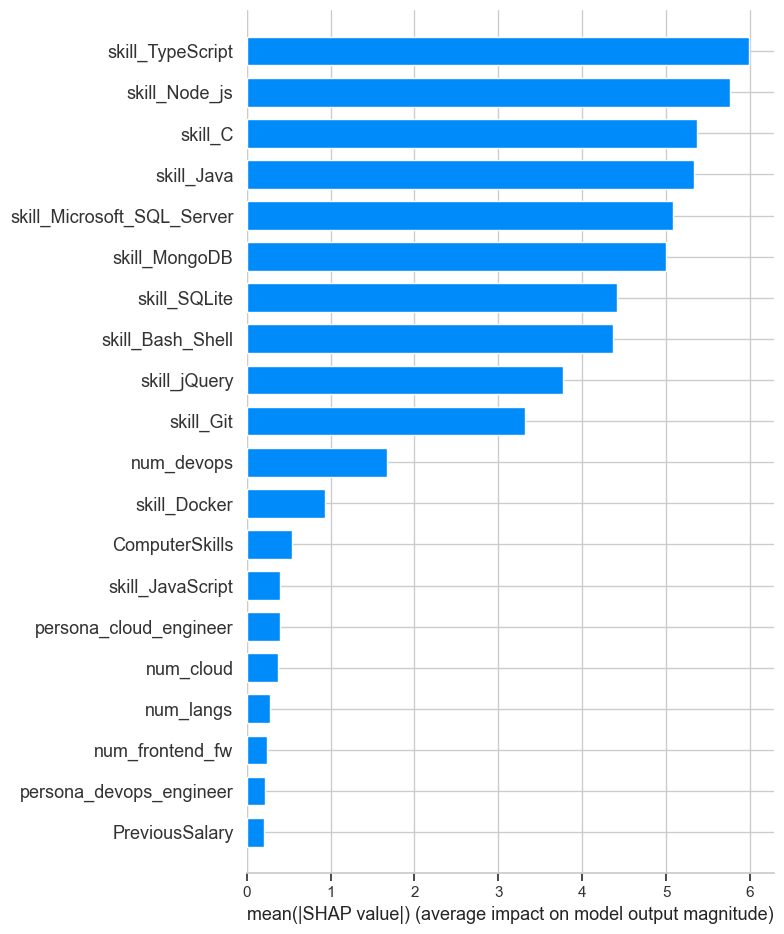


SHAP SUMMARY PLOT (BEESWARM)



SHAP DEPENDENCE PLOT
Top feature (by mean |SHAP|): skill_TypeScript



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

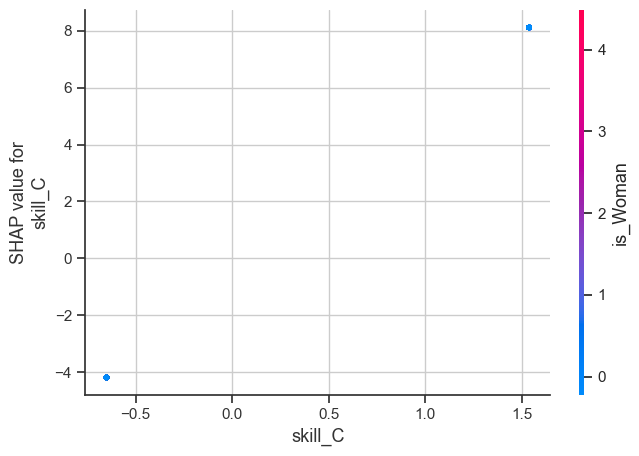

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


SHAP FORCE & WATERFALL (LOCAL)

Instance 0: true label = 1


<Figure size 640x480 with 0 Axes>

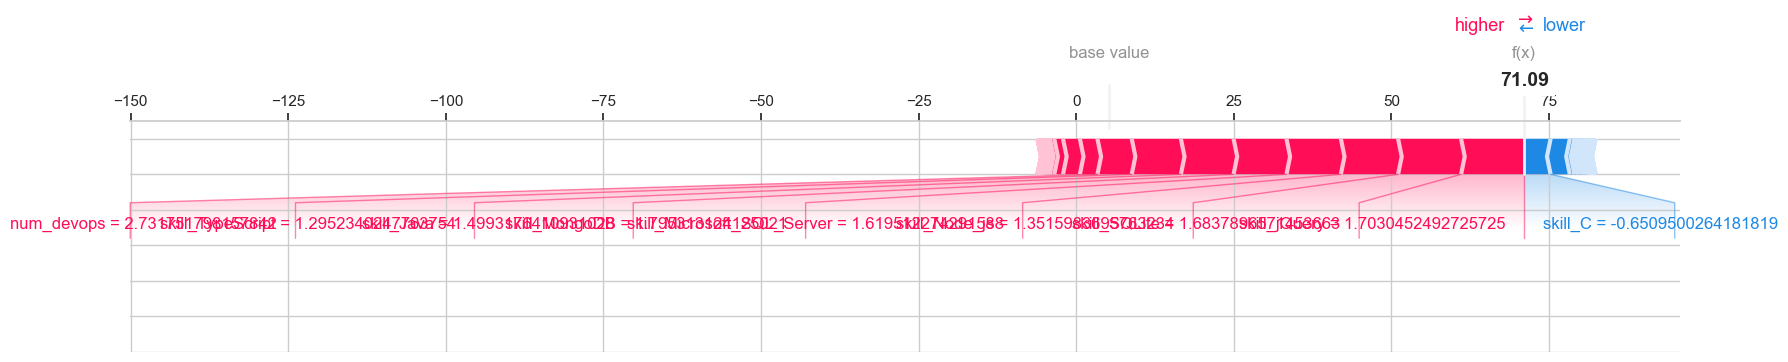

<Figure size 640x480 with 0 Axes>

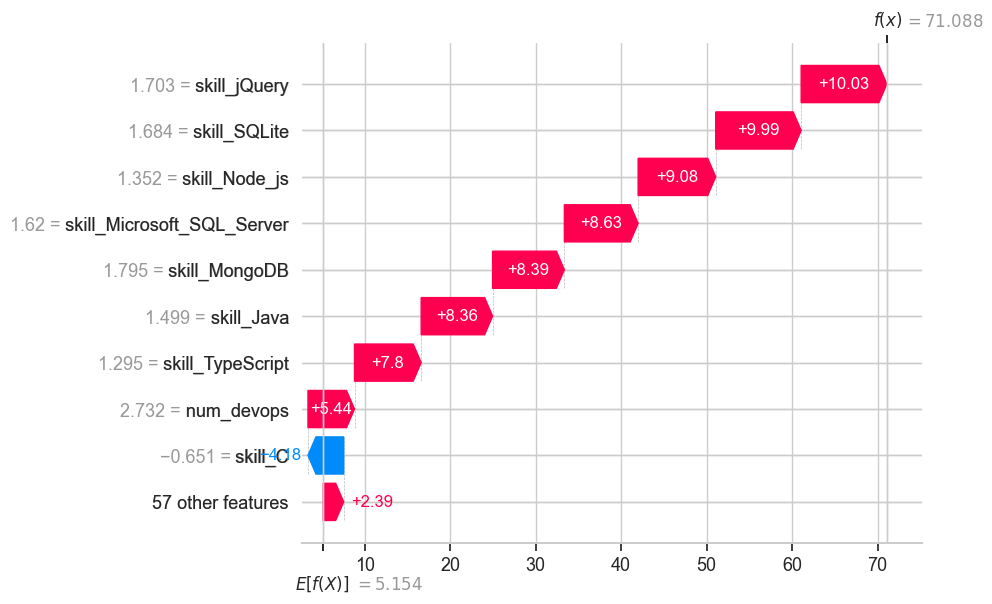

<Figure size 640x480 with 0 Axes>


Instance 1: true label = 1


<Figure size 640x480 with 0 Axes>

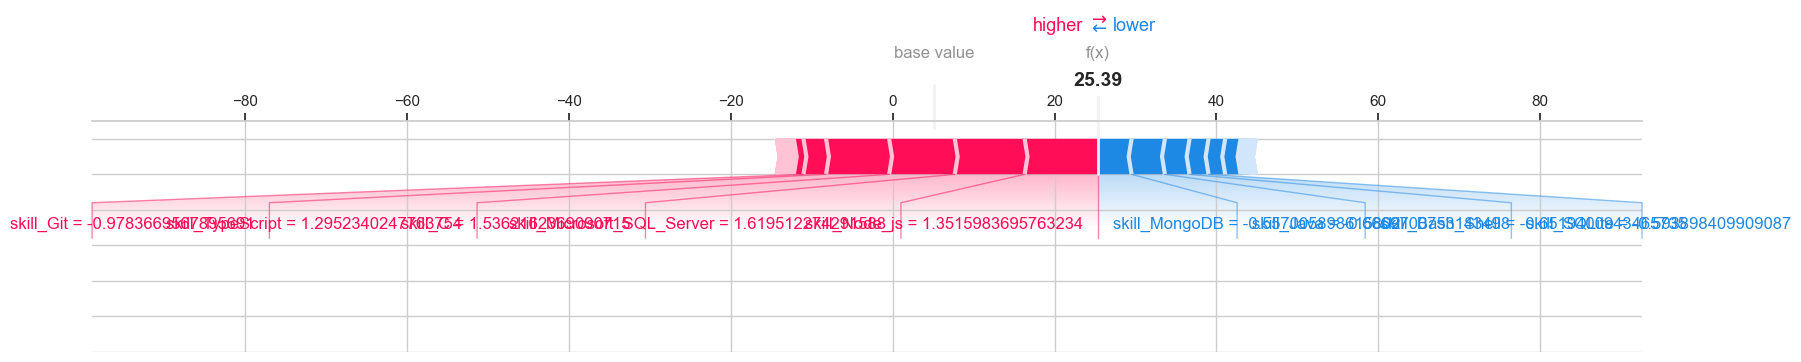

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


MODEL-BASED FEATURE IMPORTANCE
Using linear model coefficients (absolute value)...

Top 20 Features by Importance:
                       feature  importance
56               skill_Node_js    6.290212
55            skill_TypeScript    6.183758
58                  skill_Java    5.756718
60                     skill_C    5.615779
61  skill_Microsoft_SQL_Server    5.433980
62                skill_SQLite    5.417400
65               skill_MongoDB    5.325643
63                skill_jQuery    5.274963
59            skill_Bash_Shell    4.808542
50                   skill_Git    3.316282
32                  num_devops    2.048340
48                skill_Docker    0.956572
24              ComputerSkills    0.688206
31                   num_cloud    0.516642
41      persona_cloud_engineer    0.440768
46            skill_JavaScript    0.423949
26                   num_langs    0.348621
27             num_frontend_fw    0.342020
0               PreviousSalary    0.267686
38     persona_devops_en


LIME ANALYSIS (LOCAL INTERPRETABILITY)
✓ LIME Explainer created with 44039 training samples


LIME Explanation for Test Instance 0
------------------------------------------------------------
Prediction: Not Employed
Probability (Employed): 0.0002

Top 15 Contributing Features (feature, weight):
  skill_TypeScript <= -0.77: -0.0145
  skill_Node_js <= -0.74: -0.0129
  skill_C <= -0.65: -0.0128
  skill_Bash_Shell <= -0.65: -0.0122
  -0.98 < skill_Git <= 1.02: -0.0119
  skill_Microsoft_SQL_Server <= -0.62: -0.0119
  skill_Java <= -0.67: -0.0116
  num_devops <= -0.85: -0.0115
  Continent_Africa <= -0.17: 0.0112
  skill_MongoDB <= -0.56: -0.0111
  -0.59 < skill_SQLite <= 1.68: 0.0100
  -0.59 < skill_jQuery <= 1.70: 0.0100
  Accessibility_bin <= -0.17: 0.0096
  persona_game_developer <= -0.24: -0.0081
  skill_Docker <= -1.10: 0.0068


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


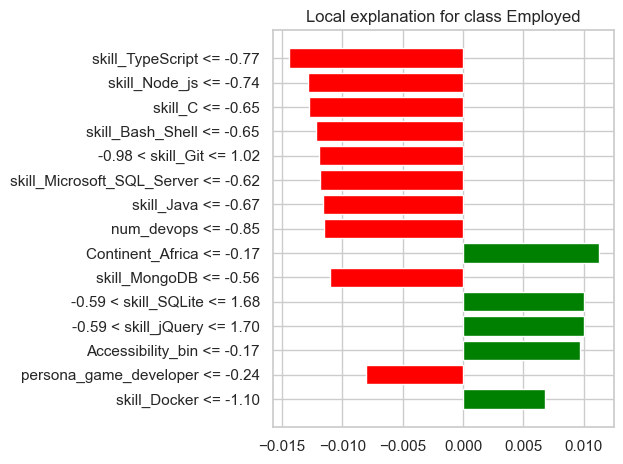


LIME Explanation for Test Instance 1
------------------------------------------------------------
Prediction: Employed
Probability (Employed): 1.0000


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Top 15 Contributing Features (feature, weight):
  Continent_Other <= -0.02: -0.0177
  Accessibility_bin <= -0.17: 0.0168
  -0.74 < skill_Node_js <= 1.35: 0.0146
  -0.67 < skill_Java <= 1.50: 0.0138
  -0.98 < skill_Git <= 1.02: -0.0137
  -0.77 < skill_TypeScript <= 1.30: 0.0133
  skill_C <= -0.65: -0.0132
  -0.65 < skill_Bash_Shell <= 1.53: 0.0128
  skill_Microsoft_SQL_Server <= -0.62: -0.0127
  skill_SQLite <= -0.59: -0.0122
  -0.59 < skill_jQuery <= 1.70: 0.0117
  skill_MongoDB > -0.56: 0.0116
  num_devops > 0.34: 0.0110
  Continent_Oceania <= -0.17: -0.0096
  ComputerSkills > 0.51: 0.0074


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


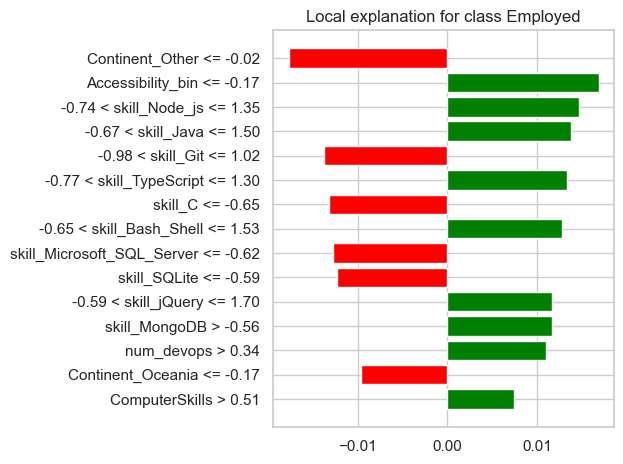


LIME Explanation for Test Instance 2
------------------------------------------------------------
Prediction: Employed
Probability (Employed): 1.0000


/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/saiashwin/Desktop/Notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Top 15 Contributing Features (feature, weight):
  Continent_Africa <= -0.17: 0.0180
  -0.77 < skill_TypeScript <= 1.30: 0.0142
  -0.98 < skill_Git <= 1.02: -0.0141
  -0.74 < skill_Node_js <= 1.35: 0.0138
  skill_Java <= -0.67: -0.0135
  persona_functional_programmer <= -0.32: 0.0121
  skill_Microsoft_SQL_Server <= -0.62: -0.0121
  -0.59 < skill_SQLite <= 1.68: 0.0120
  Continent_Oceania <= -0.17: 0.0119
  skill_C <= -0.65: -0.0117
  skill_Bash_Shell <= -0.65: -0.0116
  -0.59 < skill_jQuery <= 1.70: 0.0116
  skill_MongoDB > -0.56: 0.0106
  persona_legacy_enterprise_dev <= -0.20: -0.0071
  -0.25 < num_devops <= 0.34: 0.0071


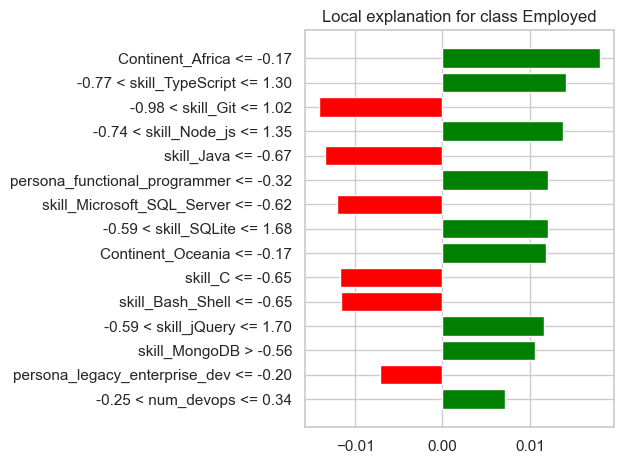


✓ SHAP & LIME ANALYSIS COMPLETE


In [12]:
# =====================================
# SHAP & LIME ANALYSIS (Complete Setup)
# =====================================

import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from scipy.special import expit

print("=" * 80)
print("SHAP & LIME ANALYSIS")
print("=" * 80)

best_model       = results["best_model"]
best_model_name  = results["best_model_name"]
preprocessor     = results["preprocessor"]
X_train_proc     = results["X_train_proc"]
X_valid_proc     = results["X_valid_proc"]
X_test_proc      = results["X_test_proc"]

print(f"Best model: {best_model_name}")
print(f"Model type: {type(best_model)}")
print(f"Processed data shape: {X_train_proc.shape}\n")

# =====================================
# 1. GET FEATURE NAMES
# =====================================

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = np.array([f"feature_{i}" for i in range(X_train_proc.shape[1])])

print(f"Number of features: {len(feature_names)}\n")

# =====================================
# 2. PREPARE DENSE MATRICES
# =====================================

if hasattr(X_train_proc, "toarray"):
    X_train_dense = X_train_proc.toarray()
    X_valid_dense = X_valid_proc.toarray()
    X_test_dense  = X_test_proc.toarray()
else:
    X_train_dense = X_train_proc.values if hasattr(X_train_proc, "values") else X_train_proc
    X_valid_dense = X_valid_proc.values if hasattr(X_valid_proc, "values") else X_valid_proc
    X_test_dense  = X_test_proc.values if hasattr(X_test_proc, "values") else X_test_proc

print(f"Dense data shapes - Train: {X_train_dense.shape}, Valid: {X_valid_dense.shape}, Test: {X_test_dense.shape}\n")

# =====================================
# 3. SHAP EXPLAINER
# =====================================

print("Creating SHAP Explainer...")

shap_sample_size = min(500, X_train_dense.shape[0])
background_idx = np.random.choice(X_train_dense.shape[0], shap_sample_size, replace=False)
X_background = X_train_dense[background_idx]

model_type = None

if isinstance(best_model, (GradientBoostingClassifier, GradientBoostingRegressor)):
    print("✓ Using TreeExplainer (Gradient Boosting detected)")
    explainer = shap.TreeExplainer(best_model, X_background)
    model_type = "tree"
elif isinstance(best_model, (LogisticRegression, RidgeClassifier)):
    print("✓ Using LinearExplainer (Linear model detected)")
    explainer = shap.LinearExplainer(best_model, X_background)
    model_type = "linear"
else:
    print("✓ Using KernelExplainer (Generic model)")
    def shap_predict_fn(x):
        if hasattr(best_model, "predict_proba"):
            return best_model.predict_proba(x)[:, 1]
        elif hasattr(best_model, "decision_function"):
            scores = best_model.decision_function(x)
            scores = np.atleast_1d(scores).reshape(-1)
            return expit(scores)
        else:
            preds = best_model.predict(x).reshape(-1)
            return preds
    explainer = shap.KernelExplainer(shap_predict_fn, X_background)
    model_type = "kernel"

print(f"Model type for SHAP: {model_type}\n")

# =====================================
# 4. COMPUTE SHAP VALUES
# =====================================

print("Computing SHAP values on validation set...")

shap_eval_size = min(500, X_valid_dense.shape[0])
X_shap = X_valid_dense[:shap_eval_size]
y_shap = y_valid[:shap_eval_size]

shap_values = explainer.shap_values(X_shap)

if isinstance(shap_values, list) and len(shap_values) == 2:
    print("Binary classification detected - using positive class SHAP values")
    shap_values = shap_values[1]

shap_values = np.array(shap_values)
print(f"✓ SHAP values shape: {shap_values.shape}\n")

shap.initjs()

# =====================================
# 5. SHAP SUMMARY PLOTS
# =====================================

print("=" * 80)
print("SHAP SUMMARY PLOT (BAR)")
print("=" * 80)

plt.figure()
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

print("\n" + "=" * 80)
print("SHAP SUMMARY PLOT (BEESWARM)")
print("=" * 80)

# Build a SHAP Explanation object explicitly
explanation = shap.Explanation(
    values=shap_values,              # (500, 41)
    base_values=explainer.expected_value,
    data=X_shap,                     # same shape as shap_values
    feature_names=list(feature_names)
)

# 1) Beeswarm (global + local)
shap.plots.beeswarm(explanation, max_display=20)
plt.show()



# =====================================
# 6. SHAP DEPENDENCE PLOTS
# =====================================

print("\n" + "=" * 80)
print("SHAP DEPENDENCE PLOT")
print("=" * 80)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_feature_idx = np.argsort(mean_abs_shap)[-1]
top_feature_name = feature_names[top_feature_idx]
print(f"Top feature (by mean |SHAP|): {top_feature_name}\n")

plt.figure()
shap.dependence_plot(
    top_feature_idx,
    shap_values,
    X_shap,
    feature_names=feature_names,
    interaction_index=None,
    show=True
)

top_3_indices = np.argsort(mean_abs_shap)[-3:]
for idx in top_3_indices:
    plt.figure()
    shap.dependence_plot(
        idx,
        shap_values,
        X_shap,
        feature_names=feature_names,
        show=True
    )

# =====================================
# 7. SHAP FORCE & WATERFALL (LOCAL)
# =====================================

print("\n" + "=" * 80)
print("SHAP FORCE & WATERFALL (LOCAL)")
print("=" * 80)

for sample_idx in [0, 1]:
    if sample_idx >= len(X_shap):
        break

    print(f"\nInstance {sample_idx}: true label = {y_shap.iloc[sample_idx] if hasattr(y_shap, 'iloc') else y_shap[sample_idx]}")

    if isinstance(explainer.expected_value, (list, np.ndarray)):
        if len(np.atleast_1d(explainer.expected_value)) > 1:
            base_value = explainer.expected_value[1]
        else:
            base_value = float(np.atleast_1d(explainer.expected_value)[0])
    else:
        base_value = float(explainer.expected_value)

    plt.figure()
    shap.force_plot(
        base_value,
        shap_values[sample_idx, :],
        X_shap[sample_idx, :],
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )
    plt.tight_layout()
    plt.show()

    plt.figure()
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[sample_idx, :],
        base_values=base_value,
        data=X_shap[sample_idx, :],
        feature_names=feature_names
    ), show=True)
    plt.tight_layout()
    plt.show()

# =====================================
# 8. MODEL-BASED FEATURE IMPORTANCE
# =====================================

print("\n" + "=" * 80)
print("MODEL-BASED FEATURE IMPORTANCE")
print("=" * 80)

importances = None

if hasattr(best_model, "feature_importances_"):
    print("Using tree-based feature importances...")
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    print("Using linear model coefficients (absolute value)...")
    coefs = best_model.coef_
    if coefs.ndim > 1:
        coefs = coefs[0]
    importances = np.abs(coefs)
else:
    print("⚠ Model does not expose feature_importances_ or coef_")

if importances is not None:
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("\nTop 20 Features by Importance:")
    print(fi_df.head(20).to_string())

    top_n = 20
    fi_top = fi_df.head(top_n)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(fi_top)), fi_top["importance"].values)
    plt.yticks(range(len(fi_top)), fi_top["feature"].values)
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_n} Features by Model-Based Importance\n({best_model_name})")
    plt.gca().invert_yaxis()
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

# =====================================
# 9. LIME ANALYSIS (LOCAL EXPLAINABILITY)
# =====================================

print("\n" + "=" * 80)
print("LIME ANALYSIS (LOCAL INTERPRETABILITY)")
print("=" * 80)

def model_predict_proba(X):
    X = np.asarray(X)
    if hasattr(best_model, "predict_proba"):
        return best_model.predict_proba(X)
    if hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X)
        scores = np.atleast_1d(scores).reshape(-1)
        probs_pos = expit(scores)
        probs_pos = np.clip(probs_pos, 1e-6, 1-1e-6)
        probs = np.vstack([1 - probs_pos, probs_pos]).T
        return probs
    preds = best_model.predict(X).reshape(-1)
    probs_pos = np.clip(preds, 1e-6, 1-1e-6)
    probs = np.vstack([1 - probs_pos, probs_pos]).T
    return probs

lime_explainer = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=feature_names.tolist(),
    class_names=["Not Employed", "Employed"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

print(f"✓ LIME Explainer created with {X_train_dense.shape[0]} training samples\n")

for sample_idx in [0, 1, 2]:
    if sample_idx >= X_test_dense.shape[0]:
        break

    print(f"\nLIME Explanation for Test Instance {sample_idx}")
    print("-" * 60)

    pred_proba = model_predict_proba(X_test_dense[sample_idx:sample_idx+1])[0]
    pred_label = np.argmax(pred_proba)

    print(f"Prediction: {['Not Employed', 'Employed'][pred_label]}")
    print(f"Probability (Employed): {pred_proba[1]:.4f}")

    exp = lime_explainer.explain_instance(
        X_test_dense[sample_idx],
        model_predict_proba,
        num_features=15
    )

    print("\nTop 15 Contributing Features (feature, weight):")
    for feat, weight in exp.as_list():
        print(f"  {feat}: {weight:.4f}")

    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("✓ SHAP & LIME ANALYSIS COMPLETE")
print("=" * 80)


Model 2: Handling Individual Skills with Vectorizer:

The updated SHAP plots make it clear that individual skills dominate the model, while persona flags contribute almost nothing. The top features by mean |SHAP| are all specific skill indicators (skill_TypeScript, skill_Node_js, skill_C, skill_Java, skill_Microsoft_SQL_Server, skill_MongoDB, etc.) and num_devops. In contrast, persona features such as persona_cloud_engineer and persona_devops_engineer sit near the bottom with very small SHAP magnitudes, and in the beeswarm their points are tightly clustered around zero.

This means that the model learns most of its signal from the exact technologies a candidate knows, not from coarse 0/1 persona labels that summarise those skills. Therefore, it is more useful to drop the persona features entirely and make the skill representation richer: instead of limiting ourselves to the top-20 skills, we will use a vectorizer over the full skill list (e.g. multi-hot / bag-of-skills). This allows the model to also pick up rare but important skills, which the persona flags were not capturing well.

- PREPROCESSING

In [17]:
text_col = "HaveWorkedWith"     
categorical_cols =df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns

print(categorical_cols)
print(numerical_cols)

['EdLevel', 'MainBranch', 'Country', 'HaveWorkedWith']
Index(['Employment', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills',
       'Employed'],
      dtype='object')


In [18]:
categorical_cols = ['EdLevel', 'MainBranch', 'Country']
numerical_cols = ['YearsCodePro', 'PreviousSalary', 'ComputerSkills']
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()  

preprocess = ColumnTransformer(
    transformers=[
        ('vectorizer', vectorizer, text_col),
        ('cat', one_hot_encoder, categorical_cols),
        ('num', scaler, numerical_cols),
    ]
)

In [19]:
# 3. Evaluation loss 
# Context: false negatives are more costly

def evaluation_loss(y_true, y_pred, fp_cost=1.0, fn_cost=5.0):
    """
    Cost-sensitive loss: FN more expensive than FP.
    y_true, y_pred are 0/1 arrays.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    fp = np.logical_and(y_true == 0, y_pred == 1).sum()
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()

    return fp_cost * fp + fn_cost * fn


In [20]:
def find_best_threshold(y_true, scores, fp_cost=1.0, fn_cost=5.0):
    """
    Given continuous scores, find threshold that minimizes evaluation_loss.
    """
    scores = np.asarray(scores)
    thresholds = np.linspace(scores.min(), scores.max(), 201)

    best_thr, best_loss = None, np.inf
    for thr in thresholds:
        y_pred = (scores >= thr).astype(int)
        loss = evaluation_loss(y_true, y_pred, fp_cost, fn_cost)
        if loss < best_loss:
            best_loss = loss
            best_thr = thr
    return best_thr, best_loss

In [21]:
# Helper to get score for AUC/ROC from any model
def get_scores(pipe, X_data):
    model = pipe.named_steps['model']
    if hasattr(model, "predict_proba"):
        scores = pipe.predict_proba(X_data)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = pipe.decision_function(X_data)
    else:
        scores = pipe.predict(X_data)
    return scores

In [22]:
# 4. Define models
#    Glassbox: linear, Blackbox: tree-based
#    Each with L2 vs log-loss surrogates

# ---- Glassbox models ----
glassbox_L2 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RidgeClassifier(  # squared-error surrogate (L2-like)
        alpha=1.0,
        random_state=42
    ))
])

glassbox_logloss = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        penalty='l2',
        solver='liblinear',  # or 'lbfgs' for larger datasets
        max_iter=1000,
        random_state=42
    ))
])

sgd_L2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SGDClassifier(
        loss="squared_error",     # L2 surrogate classification
        penalty="l2",
        max_iter=2000,
        learning_rate="optimal",
        random_state=42
    ))
])

sgd_logloss = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SGDClassifier(
        loss="log_loss",          # logistic surrogate loss
        penalty="l2",
        max_iter=2000,
        learning_rate="optimal",
        random_state=42
    ))
])

# ---- Blackbox models (tree-based) ----
blackbox_L2 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingRegressor(
        loss='squared_error',    # L2 loss
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

blackbox_logloss = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingClassifier(
        loss='log_loss',         # logistic surrogate loss
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

models = {
    "glassbox_L2_Ridge": glassbox_L2,
    "glassbox_logloss_LogReg": glassbox_logloss,
    "glassbox_sgd_L2": sgd_L2,
    "glassbox_sgd_logloss": sgd_logloss,
    "blackbox_L2_GBReg": blackbox_L2,
    "blackbox_logloss_GBCls": blackbox_logloss,
}


=== Training glassbox_L2_Ridge ===


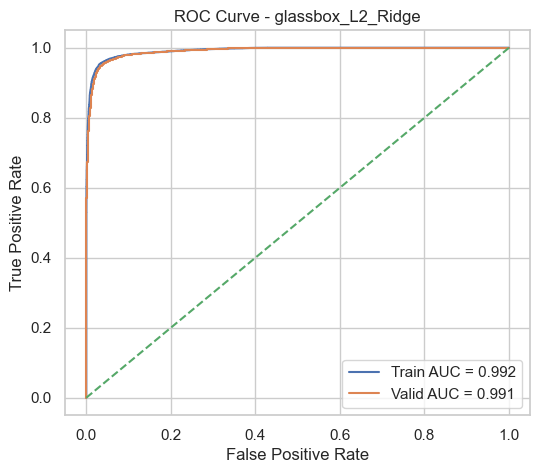


=== Training glassbox_logloss_LogReg ===


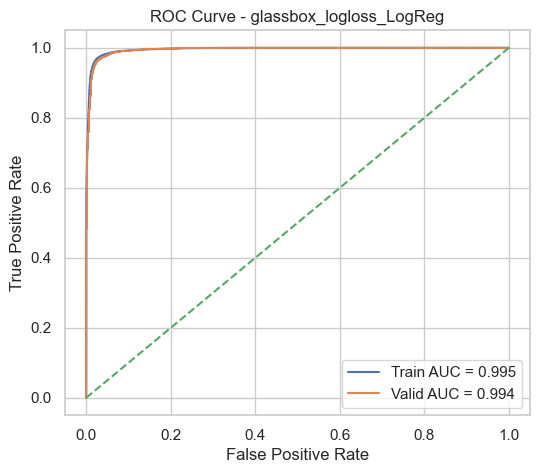


=== Training glassbox_sgd_L2 ===


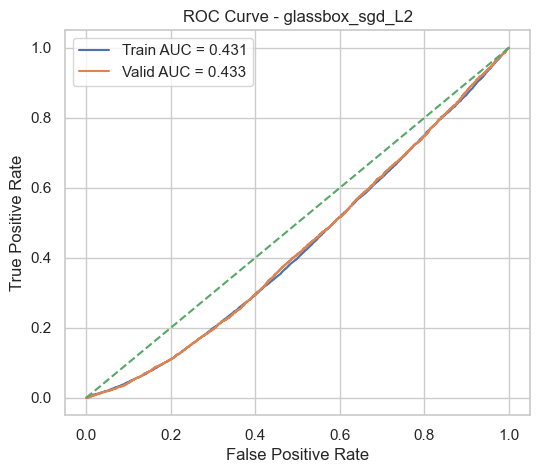


=== Training glassbox_sgd_logloss ===



=== Training blackbox_L2_GBReg ===


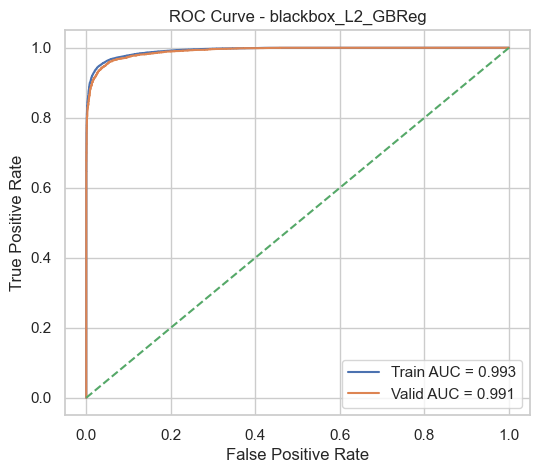


=== Training blackbox_logloss_GBCls ===


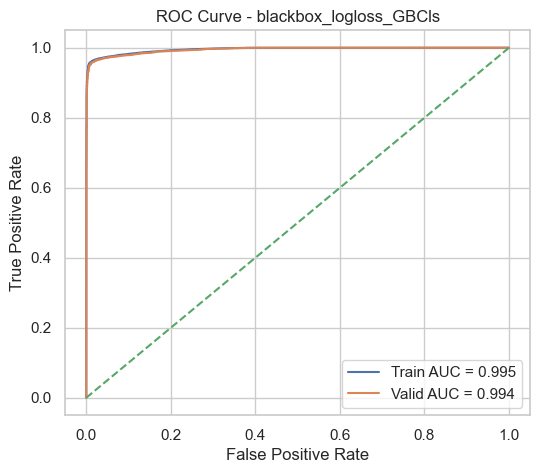


Validation results (sorted by validation AUC):
                model_name  auc_train  auc_valid  \
1  glassbox_logloss_LogReg   0.995381   0.994314   
5   blackbox_logloss_GBCls   0.995127   0.994295   
3     glassbox_sgd_logloss   0.993848   0.992739   
4        blackbox_L2_GBReg   0.992810   0.991073   
0        glassbox_L2_Ridge   0.991870   0.990512   
2          glassbox_sgd_L2   0.430717   0.432853   

   misclassification_loss_valid_default_thr  evaluation_loss_valid_default_thr  
1                                  0.032629                             1335.0  
5                                  0.030995                             1575.0  
3                                  0.038965                             1608.0  
4                                  0.048365                             2550.0  
0                                  0.046866                             2700.0  
2                                  0.550886                            27555.0  


In [23]:
# 5. Train all models, compute metrics & plot ROC curves

results = []

for name, pipe in models.items():
    print(f"\n=== Training {name} ===")
    pipe.fit(X_train, y_train)

    # Scores for train & validation
    scores_train = get_scores(pipe, X_train)
    scores_valid = get_scores(pipe, X_valid)

    # AUC for train & validation
    auc_train = roc_auc_score(y_train, scores_train)
    auc_valid = roc_auc_score(y_valid, scores_valid)

    # Choose a "default" threshold only for comparison (0.5 where appropriate)
    if scores_valid.min() >= 0 and scores_valid.max() <= 1:
        default_thr = 0.5
    else:
        default_thr = scores_valid.mean()  # fallback

    y_pred_valid_default = (scores_valid >= default_thr).astype(int)

    misclf_loss_default = 1 - accuracy_score(y_valid, y_pred_valid_default)
    eval_loss_default = evaluation_loss(y_valid, y_pred_valid_default)

    results.append({
        "model_name": name,
        "auc_train": auc_train,
        "auc_valid": auc_valid,
        "misclassification_loss_valid_default_thr": misclf_loss_default,
        "evaluation_loss_valid_default_thr": eval_loss_default
    })

    # ---- ROC curves for train vs validation (overfitting check) ----
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, scores_valid)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
    plt.plot(fpr_valid, tpr_valid, label=f"Valid AUC = {auc_valid:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Collect results
results_df = pd.DataFrame(results).sort_values(by="auc_valid", ascending=False)
print("\nValidation results (sorted by validation AUC):")
print(results_df)

In [24]:
# 6. Choose best model by validation AUC

best_row = results_df.iloc[0]
best_model_name = best_row["model_name"]
best_model = models[best_model_name]

print(f"\nChosen model based on validation AUC: {best_model_name}")


Chosen model based on validation AUC: glassbox_logloss_LogReg


In [25]:
# 7. Best threshold (minimizing evaluation loss) on validation

best_scores_valid = get_scores(best_model, X_valid)
best_thr, best_eval_loss_valid = find_best_threshold(
    y_true=y_valid,
    scores=best_scores_valid,
    fp_cost=1.0,
    fn_cost=5.0 
)

y_valid_pred_best = (best_scores_valid >= best_thr).astype(int)

final_auc_valid = roc_auc_score(y_valid, best_scores_valid)
final_misclf_valid = 1 - accuracy_score(y_valid, y_valid_pred_best)

print(f"\nBest threshold (validation) for chosen model: {best_thr:.4f}")
print(f"Evaluation loss (validation) at best threshold: {best_eval_loss_valid:.2f}")
print(f"Validation AUC (chosen model): {final_auc_valid:.4f}")
print(f"Misclassification loss (validation) at best threshold: {final_misclf_valid:.4f}")
print("\nClassification report (validation, chosen model):")
print(classification_report(y_valid, y_valid_pred_best))
print("Confusion matrix (validation, chosen model):")
print(confusion_matrix(y_valid, y_valid_pred_best))


Best threshold (validation) for chosen model: 0.3050
Evaluation loss (validation) at best threshold: 938.00
Validation AUC (chosen model): 0.9943
Misclassification loss (validation) at best threshold: 0.0405

Classification report (validation, chosen model):
              precision    recall  f1-score   support

           0       0.99      0.93      0.95      6801
           1       0.94      0.99      0.96      7879

    accuracy                           0.96     14680
   macro avg       0.96      0.96      0.96     14680
weighted avg       0.96      0.96      0.96     14680

Confusion matrix (validation, chosen model):
[[6293  508]
 [  86 7793]]



=== Test set performance (chosen model, best threshold from validation) ===
Test AUC: 0.9952
Misclassification loss (test): 0.0368
Evaluation loss (test): 968.00

Classification report (test, chosen model):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      6802
           1       0.95      0.99      0.97      7878

    accuracy                           0.96     14680
   macro avg       0.97      0.96      0.96     14680
weighted avg       0.96      0.96      0.96     14680

Confusion matrix (test, chosen model):
[[6369  433]
 [ 107 7771]]


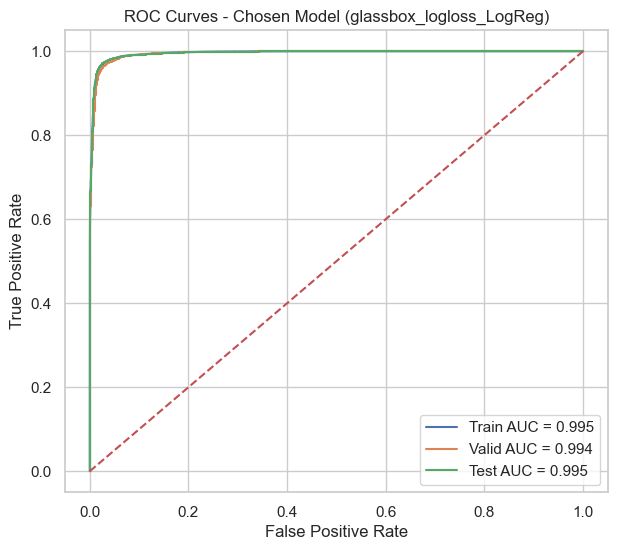

In [26]:
# 8. Evaluate chosen model on TEST set
# (using SAME threshold selected from validation)

best_scores_test = get_scores(best_model, X_test)
y_test_pred_best = (best_scores_test >= best_thr).astype(int)

auc_test = roc_auc_score(y_test, best_scores_test)
misclf_test = 1 - accuracy_score(y_test, y_test_pred_best)
eval_loss_test = evaluation_loss(y_test, y_test_pred_best)

print("\n=== Test set performance (chosen model, best threshold from validation) ===")
print(f"Test AUC: {auc_test:.4f}")
print(f"Misclassification loss (test): {misclf_test:.4f}")
print(f"Evaluation loss (test): {eval_loss_test:.2f}")
print("\nClassification report (test, chosen model):")
print(classification_report(y_test, y_test_pred_best))
print("Confusion matrix (test, chosen model):")
print(confusion_matrix(y_test, y_test_pred_best))

# ROC curves for chosen model on train, valid, test
best_scores_train = get_scores(best_model, X_train)

fpr_train, tpr_train, _ = roc_curve(y_train, best_scores_train)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, best_scores_valid)
fpr_test, tpr_test, _ = roc_curve(y_test, best_scores_test)

plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_score(y_train, best_scores_train):.3f}")
plt.plot(fpr_valid, tpr_valid, label=f"Valid AUC = {final_auc_valid:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Chosen Model ({best_model_name})")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# After all models are fitted
preproc = best_model.named_steps["preprocess"]

X_train_trans = preproc.transform(X_train)
X_valid_trans = preproc.transform(X_valid)
X_test_trans  = preproc.transform(X_test)

print("Transformed shapes:")
print("Train:", X_train_trans.shape)
print("Valid:", X_valid_trans.shape)
print("Test:",  X_test_trans.shape)


Transformed shapes:
Train: (44039, 295)
Valid: (14680, 295)
Test: (14680, 295)



Fitting tree-based blackbox model for SHAP: blackbox_logloss_GBCls


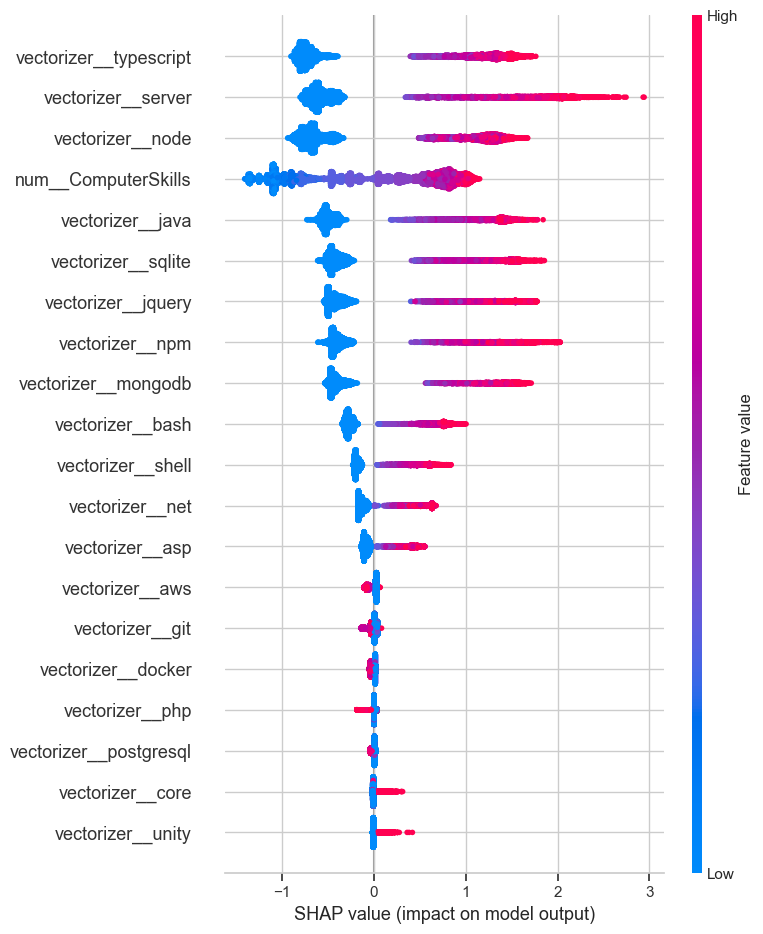

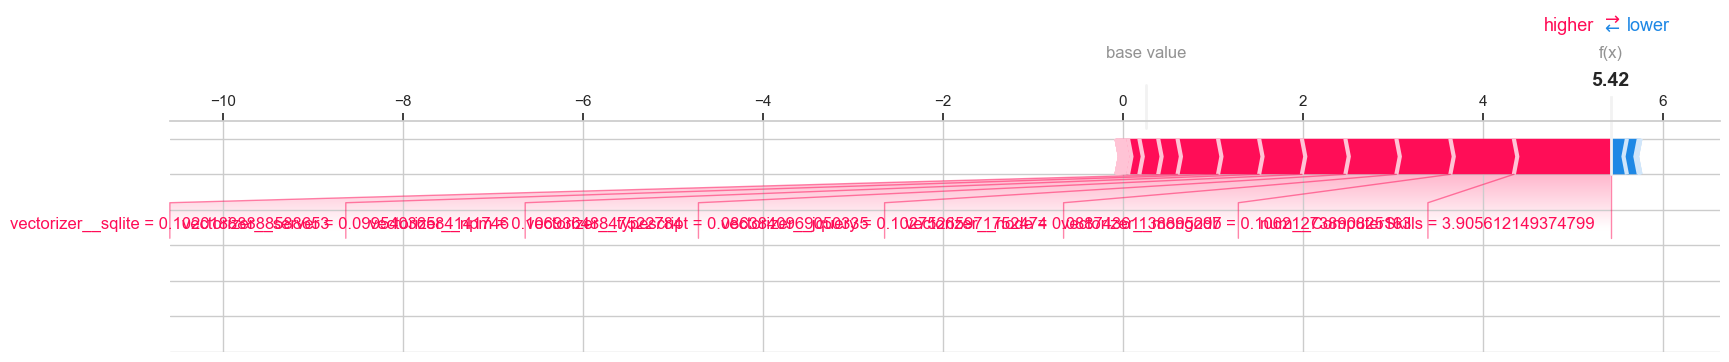

In [28]:
# 9. SHAP on a tree-based blackbox model
tree_model_name = "blackbox_logloss_GBCls"
tree_model = models[tree_model_name]

print(f"\nFitting tree-based blackbox model for SHAP: {tree_model_name}")
tree_model.fit(X_train, y_train)

# Transform validation features for SHAP
X_valid_transformed = tree_model.named_steps['preprocess'].transform(X_valid)

# Convert to dense for SHAP if sparse
if hasattr(X_valid_transformed, "toarray"):
    X_valid_dense = X_valid_transformed.toarray()
else:
    X_valid_dense = X_valid_transformed

feature_names = tree_model.named_steps['preprocess'].get_feature_names_out()
gb_inner = tree_model.named_steps['model']

explainer = shap.TreeExplainer(gb_inner)
shap_values = explainer.shap_values(X_valid_dense)

# Handle binary classifier: shap_values can be list or array depending on SHAP version
if isinstance(shap_values, list):
    # take the SHAP values for the positive class
    shap_values_to_use = shap_values[1]
else:
    shap_values_to_use = shap_values

# ---- Global SHAP: summary plot ----
shap.summary_plot(shap_values_to_use, X_valid_dense, feature_names=feature_names)

# ---- Local SHAP: one example ----
idx = 0  # index of the validation sample you want to explain
shap.force_plot(
    explainer.expected_value,
    shap_values_to_use[idx, :],
    X_valid_dense[idx, :],
    feature_names=feature_names,
    matplotlib=True
)

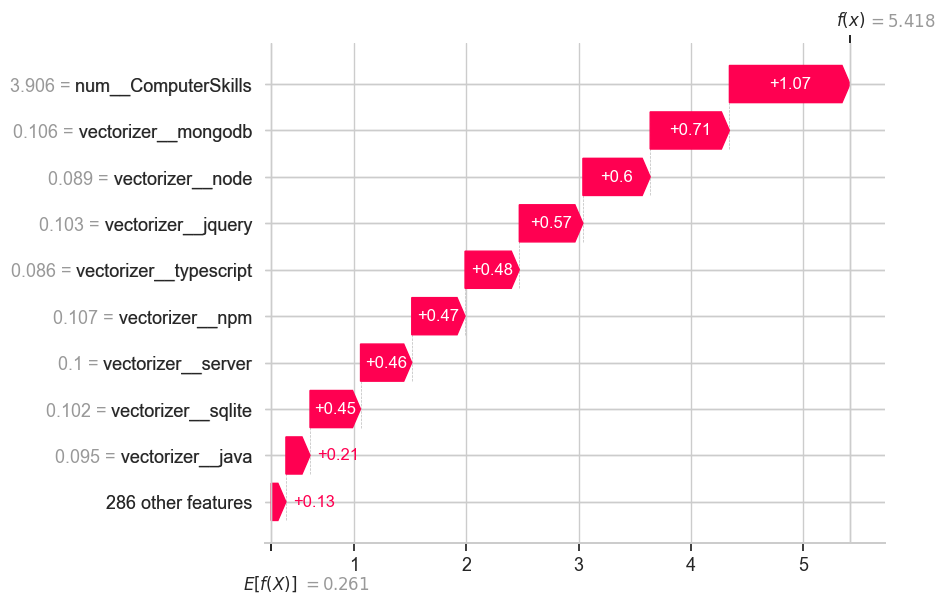

In [29]:
# A waterfall plot (more detailed local explanation)
shap.waterfall_plot(shap.Explanation(
    values=shap_values_to_use[idx, :],
    base_values=explainer.expected_value,
    data=X_valid_dense[idx, :],
    feature_names=feature_names
))

- more LOCAL SHAP explanations

In [31]:
def explain_instance(idx):
    print(f"\n=== Explaining instance {idx} ===")
    display(X_valid.iloc[idx])

    shap.force_plot(
        explainer.expected_value,
        shap_values_to_use[idx],
        X_valid_dense[idx],
        feature_names=feature_names,
        matplotlib=True
    )


Index with highest predicted probability: 6789


EdLevel                                               Undergraduate
Employment                                                        1
MainBranch                                                      Dev
YearsCodePro                                                     12
Country                                                      Turkey
PreviousSalary                                               4071.0
HaveWorkedWith    C;C#;C++;Clojure;Dart;Elixir;Erlang;Go;HTML/CS...
ComputerSkills                                                   65
Name: 48585, dtype: object

Index with lowest predicted probability: 5077


EdLevel                Other
Employment                 0
MainBranch            NotDev
YearsCodePro               3
Country                India
PreviousSalary       23460.0
HaveWorkedWith    Python;Git
ComputerSkills             2
Name: 11923, dtype: object


=== Explaining instance 0 ===


EdLevel                                               Undergraduate
Employment                                                        1
MainBranch                                                      Dev
YearsCodePro                                                      6
Country                                                    Ethiopia
PreviousSalary                                              28890.0
HaveWorkedWith    Go;Java;JavaScript;Perl;PHP;PowerShell;Python;...
ComputerSkills                                                   41
Name: 68842, dtype: object

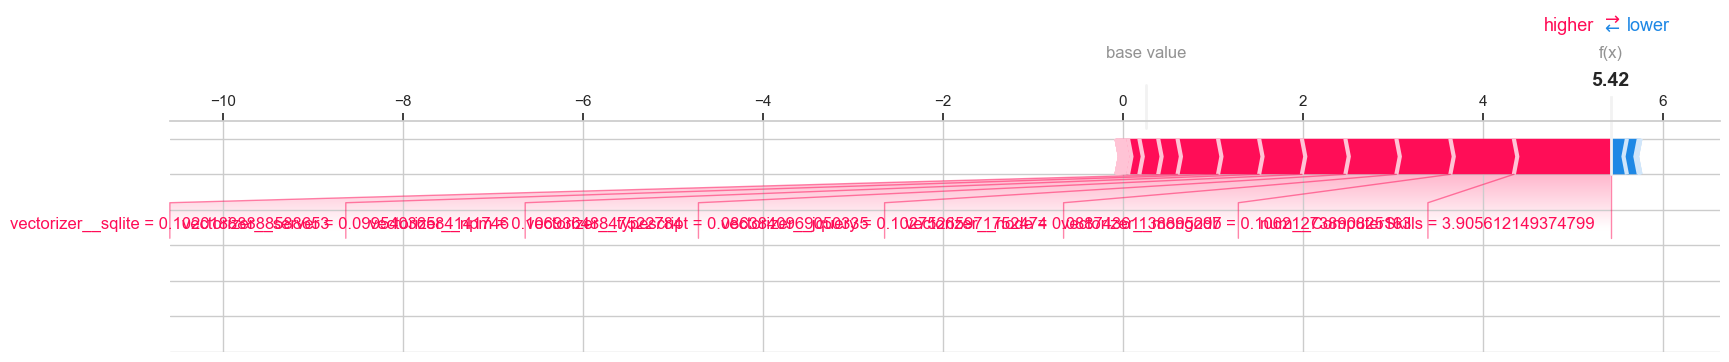


=== Explaining instance 6789 ===


EdLevel                                               Undergraduate
Employment                                                        1
MainBranch                                                      Dev
YearsCodePro                                                     12
Country                                                      Turkey
PreviousSalary                                               4071.0
HaveWorkedWith    C;C#;C++;Clojure;Dart;Elixir;Erlang;Go;HTML/CS...
ComputerSkills                                                   65
Name: 48585, dtype: object

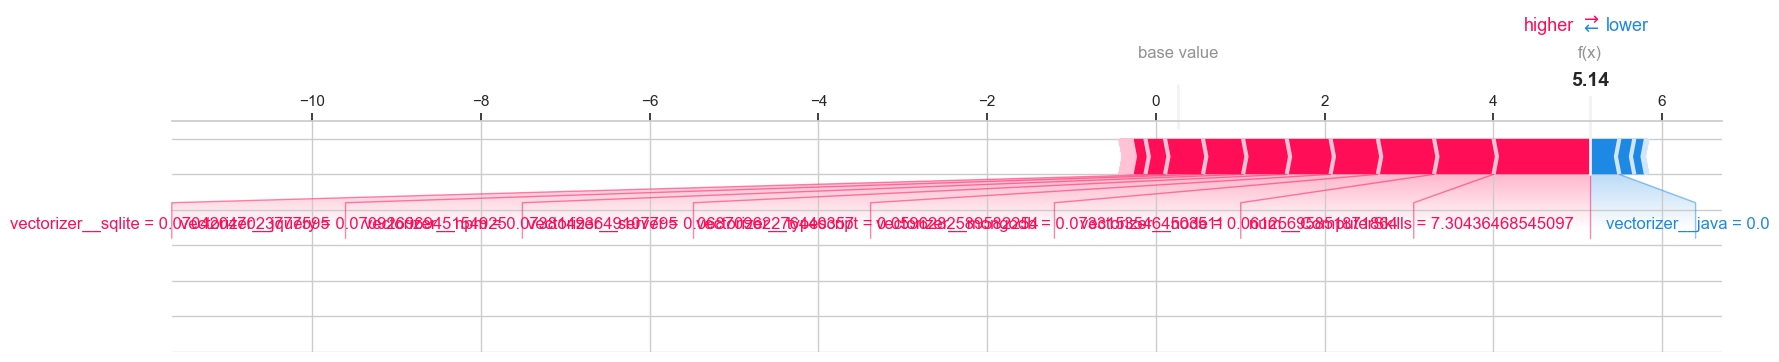


=== Explaining instance 5077 ===


EdLevel                Other
Employment                 0
MainBranch            NotDev
YearsCodePro               3
Country                India
PreviousSalary       23460.0
HaveWorkedWith    Python;Git
ComputerSkills             2
Name: 11923, dtype: object

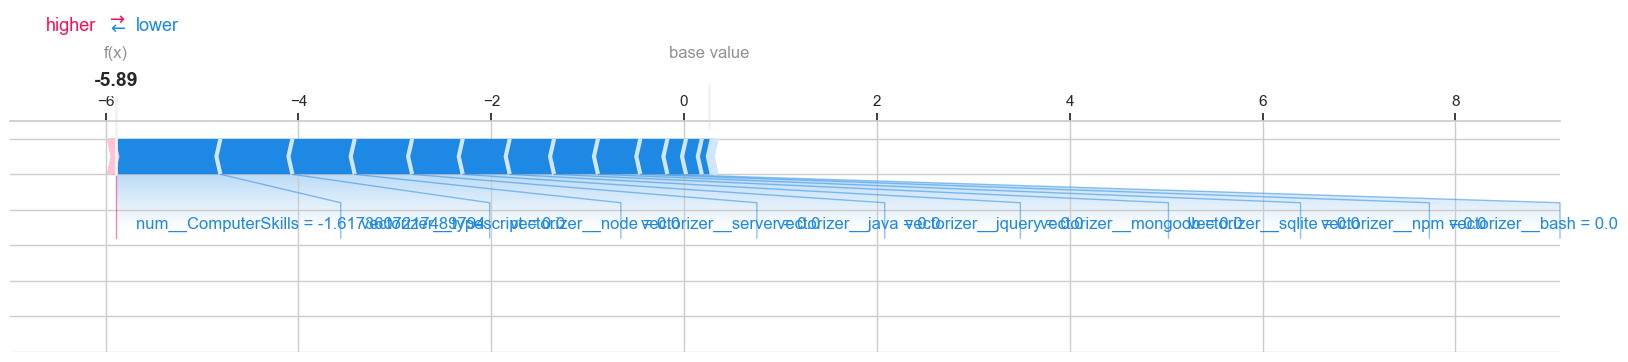


=== Explaining instance 2800 ===


EdLevel                                               Undergraduate
Employment                                                        1
MainBranch                                                      Dev
YearsCodePro                                                     12
Country                                                       India
PreviousSalary                                              28374.0
HaveWorkedWith    Bash/Shell;HTML/CSS;Java;JavaScript;SQL;TypeSc...
ComputerSkills                                                   16
Name: 72697, dtype: object

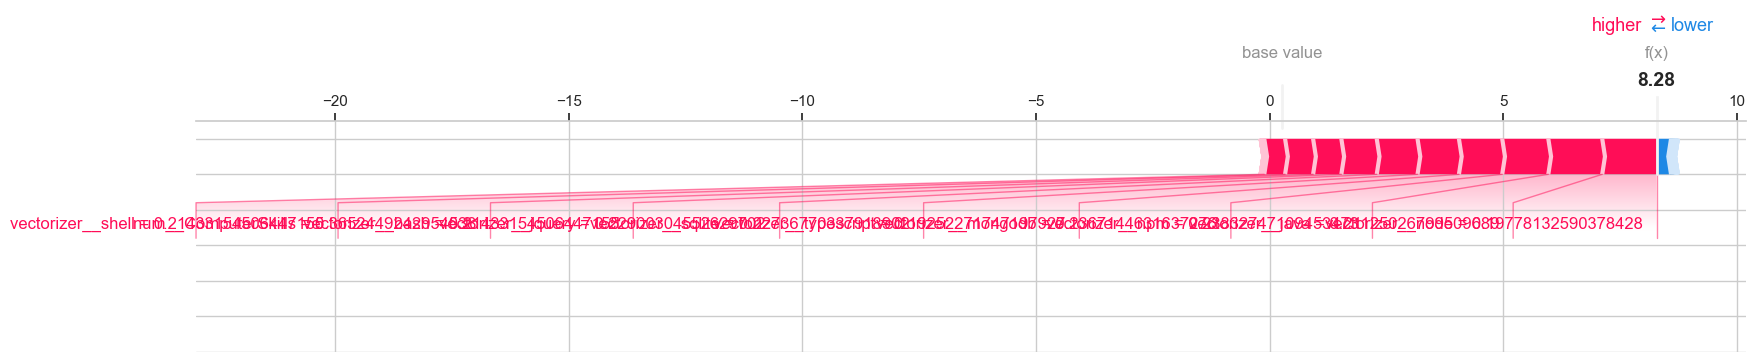


=== Explaining instance 3072 ===


EdLevel                                       Undergraduate
Employment                                                1
MainBranch                                              Dev
YearsCodePro                                             13
Country                                           Australia
PreviousSalary                                     123849.0
HaveWorkedWith    Go;Docker;Kubernetes;AWS;PostgreSQL;Redis
ComputerSkills                                            6
Name: 51371, dtype: object

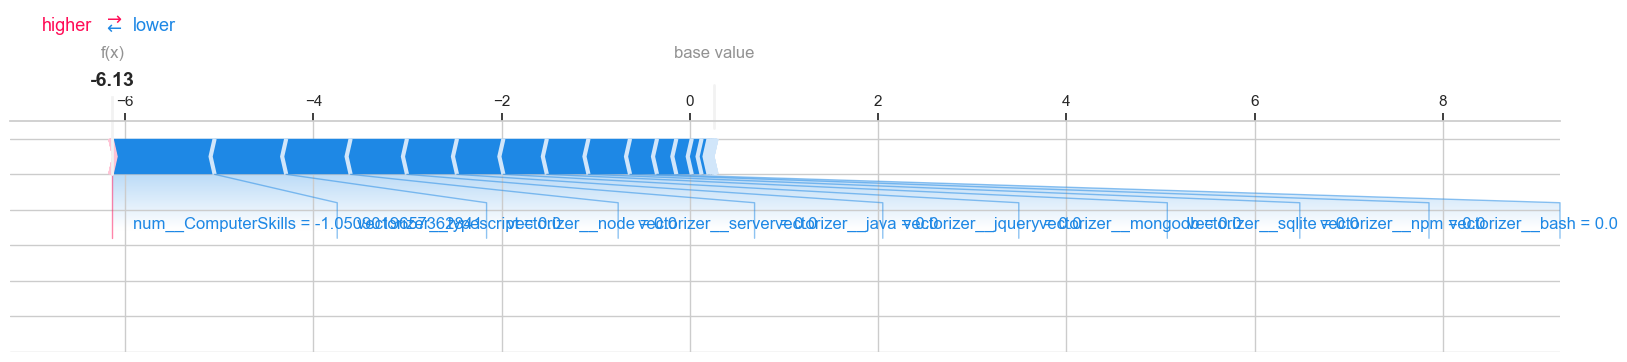


=== Explaining instance 12870 ===


EdLevel                                               Undergraduate
Employment                                                        1
MainBranch                                                      Dev
YearsCodePro                                                      6
Country                                                       India
PreviousSalary                                              12063.0
HaveWorkedWith    C#;HTML/CSS;JavaScript;Node.js;SQL;TypeScript;...
ComputerSkills                                                   12
Name: 30927, dtype: object

In [32]:
scores = best_model.predict_proba(X_valid)[:, 1]
idx_high = scores.argmax()

print("Index with highest predicted probability:", idx_high)
display(X_valid.iloc[idx_high])

idx_low = scores.argmin()

print("Index with lowest predicted probability:", idx_low)
display(X_valid.iloc[idx_low])

idx_most_positive = shap_values_to_use.sum(axis=1).argmax()

idx_most_negative = shap_values_to_use.sum(axis=1).argmin()

idx_random = np.random.randint(0, len(X_valid))


explain_instance(0)
explain_instance(idx_high)
explain_instance(idx_low)
explain_instance(idx_most_positive)
explain_instance(idx_most_negative)
explain_instance(idx_random)



- Interpretability of chosen glassbox model

hello
Using glassbox model for interpretability: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'HaveWorkedWith'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['EdLevel', 'MainBranch',
                                                   'Country']),
                                                 ('num', StandardScaler(),
                                                  ['YearsCodePro',
                                                   'PreviousSalary',
                                                   'ComputerSkills'])])),
                ('model',
                 LogisticRegression(max_iter=1000, random_state=42,
                                

feature  coefficient   abs_coef      sign
110  vectorizer__typescript    16.914797  16.914797  positive
74         vectorizer__node    15.877110  15.877110  positive
57       vectorizer__jquery    14.567380  14.567380  positive
70      vectorizer__mongodb    14.522500  14.522500  positive
75          vectorizer__npm    13.716917  13.716917  positive
105      vectorizer__sqlite    13.503510  13.503510  positive
100      vectorizer__server    12.852197  12.852197  positive
55         vectorizer__java    12.842368  12.842368  positive
8          vectorizer__bash     7.566255   7.566255  positive
101       vectorizer__shell     7.566255   7.566255  positive
69    vectorizer__microsoft     7.088335   7.088335  positive
294     num__ComputerSkills     5.090975   5.090975  positive
7         vectorizer__azure    -4.846058   4.846058  negative
91       vectorizer__python    -3.542891   3.542891  negative
45          vectorizer__git    -3.153149   3.153149  negative
93        vectorizer__react    -3.119660   3.119660  negative
56   vectorizer__javascript    -2.962614   2.962614  negative
73          vectorizer__net     2.869500   2.869500  positive
4           vectorizer__asp     2.869500   2.869500  positive
16         vectorizer__core     2.823253   2.823253  positive

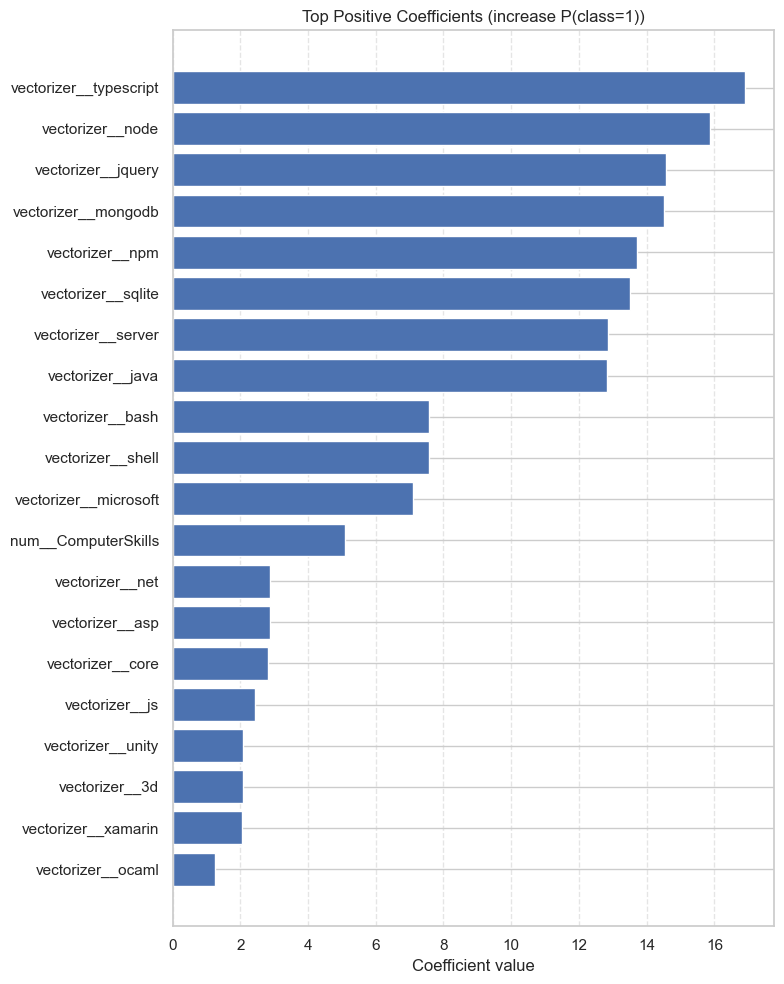


Local explanation for test instance #0
Predicted probability of class 1: 0.0715

Top features driving this prediction:


feature     value  coefficient  contribution  \
57           vectorizer__jquery  0.369971    14.567380      5.389510   
105          vectorizer__sqlite  0.367329    13.503510      4.960233   
294         num__ComputerSkills -0.626058     5.090975     -3.187245   
125      cat__MainBranch_NotDev  1.000000    -1.644455     -1.644455   
91           vectorizer__python  0.291069    -3.542891     -1.031227   
45              vectorizer__git  0.268778    -3.153149     -0.847498   
87       vectorizer__postgresql  0.297088    -2.563635     -0.761626   
27           vectorizer__django  0.517447    -1.281029     -0.662864   
71            vectorizer__mysql  0.299070    -2.119979     -0.634023   
123  cat__EdLevel_Undergraduate  1.000000    -0.550436     -0.550436   
20              vectorizer__css  0.250771    -1.007705     -0.252703   
52             vectorizer__html  0.250771    -1.007705     -0.252703   
147         cat__Country_Brazil  1.000000    -0.034857     -0.034857   
293         num__PreviousSalary -1.062257    -0.020801      0.022096   
292           num__YearsCodePro -0.642771    -0.011960      0.007687   

     abs_contribution  
57           5.389510  
105          4.960233  
294          3.187245  
125          1.644455  
91           1.031227  
45           0.847498  
87           0.761626  
27           0.662864  
71           0.634023  
123          0.550436  
20           0.252703  
52           0.252703  
147          0.034857  
293          0.022096  
292          0.007687

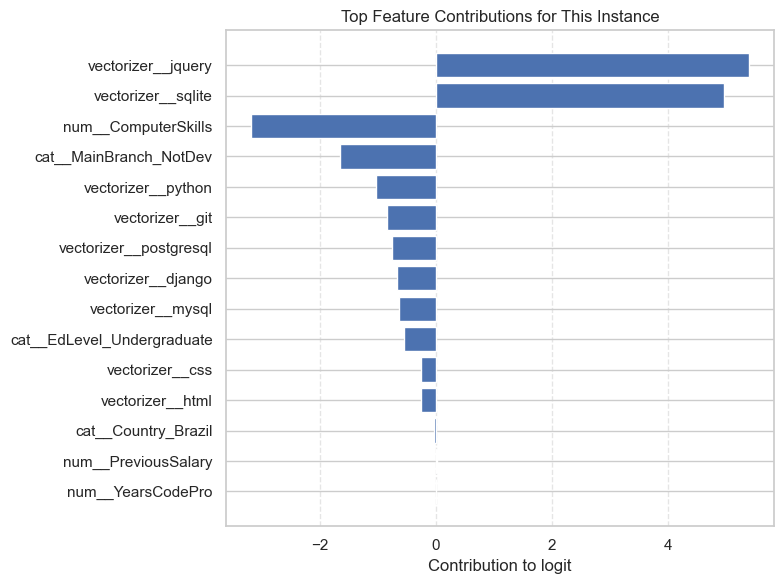

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Pick the best GLASSBOX model 

# If the chosen model is already glassbox, use it.
# Otherwise, fall back to the logistic glassbox model.
if best_model_name.startswith("glassbox"):
    best_glassbox_model = best_model   
else:
    best_glassbox_model = glassbox_logloss    # Pipeline for LogisticRegression

print("Using glassbox model for interpretability:", best_glassbox_model)

# Sanity check
print(type(best_glassbox_model))

# 2. GLOBAL INTERPRETABILITY: coefficients

# Extract inner pieces
preproc = best_glassbox_model.named_steps["preprocess"]
linear_model = best_glassbox_model.named_steps["model"]

# All feature names after ColumnTransformer (TF-IDF + OHE + numeric)
feature_names = preproc.get_feature_names_out()

# Coefficients (binary case → shape (1, n_features))
coef = linear_model.coef_.ravel()

# Build importance table
importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
})
importance["abs_coef"] = importance["coefficient"].abs()
importance["sign"] = np.where(importance["coefficient"] >= 0, "positive", "negative")

# Sort by absolute coefficient
importance = importance.sort_values("abs_coef", ascending=False)

print("\nTop 20 most influential features (by |coefficient|):")
display(importance.head(20))

# 3. PLOT: top positive & negative coefficients

top_k = 20  # change if you want more/less displayed

top_pos = importance[importance["coefficient"] > 0].head(top_k)
top_neg = importance[importance["coefficient"] < 0].tail(top_k)

plt.figure(figsize=(8, 10))
plt.barh(top_pos["feature"], top_pos["coefficient"])
plt.title("Top Positive Coefficients (increase P(class=1))")
plt.xlabel("Coefficient value")
plt.gca().invert_yaxis()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 10))
plt.barh(top_neg["feature"], top_neg["coefficient"])
plt.title("Top Negative Coefficients (decrease P(class=1))")
plt.xlabel("Coefficient value")
plt.gca().invert_yaxis()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 4. LOCAL INTERPRETABILITY: explain a single prediction

def explain_single_instance(pipe, x_row, feature_names, top_k=15):
    """
    pipe        : fitted Pipeline (preprocess + linear model)
    x_row       : pandas Series or single-row DataFrame (raw features)
    feature_names: list/array of transformed feature names
    top_k       : number of largest contributions to show
    """
    preproc = pipe.named_steps["preprocess"]
    linear = pipe.named_steps["model"]

    # Ensure 2D
    if isinstance(x_row, pd.Series):
        x_row_df = x_row.to_frame().T
    else:
        x_row_df = x_row

    # Transform to model space
    x_trans = preproc.transform(x_row_df)
    if hasattr(x_trans, "toarray"):  # sparse → dense
        x_trans = x_trans.toarray()

    x_vec = x_trans[0]
    coef = linear.coef_.ravel()

    # Contributions = coefficient * feature value
    contrib = x_vec * coef

    # Logit & probability
    logit = np.dot(x_vec, coef) + linear.intercept_[0]
    prob = 1 / (1 + np.exp(-logit))

    contrib_df = pd.DataFrame({
        "feature": feature_names,
        "value": x_vec,
        "coefficient": coef,
        "contribution": contrib
    })
    contrib_df["abs_contribution"] = contrib_df["contribution"].abs()
    contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

    print(f"Predicted probability of class 1: {prob:.4f}")
    print("\nTop features driving this prediction:")
    display(contrib_df.head(top_k))

    # Plot bar chart of contributions
    top = contrib_df.head(top_k)
    plt.figure(figsize=(8, 6))
    plt.barh(top["feature"], top["contribution"])
    plt.xlabel("Contribution to logit")
    plt.title("Top Feature Contributions for This Instance")
    plt.gca().invert_yaxis()
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return contrib_df

# Example: explain first test sample
idx = 0
print(f"\nLocal explanation for test instance #{idx}")
_ = explain_single_instance(best_glassbox_model, X_test.iloc[idx], feature_names)
